In [1]:
from astropy.timeseries import BoxLeastSquares
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import scipy
import glob
import os
import pandas as pd
import lightkurve as lk

import csv
# import time
from astropy.table import Table
import time as imp_t
from tqdm import tqdm
import itertools

# below still needs unit tests 

In [2]:
def one_transit(t=np.linspace(0,27,19440), 
           per=1., rp=0.1, t0=1., a=15., inc=87., ecc=0., 
           w=90., limb_dark ='nonlinear', u=[0.5,0.1,0.1,-0.1]):
        
    """
    ~Simulates a one-sector long TESS light curve with injected planet transits per input parameters.~
    Requires: batman; numpy
    Args:     t          =times at which to calculate light curve, default is one TESS sector;
              per        =orbital period;
              rp         =planet radius (in units of stellar radii);
              t0         =time of inferior conjunction);
              a          =semi-major axis (in units of stellar radii);
              inc        =orbital inclination (in degrees);
              ecc        =eccentricity;
              w          =longitude of periastron (in degrees);
              limb_dark  =limb darkening model;
              u          =limb darkening coefficients [u1, u2, u3, u4];
    
    outputs: flux array  =light curve with one injected transit at per, for use right before sim_lc to get TESS lc
    
    """
    #### maybe should make params its own fcn and split this fcn into 2....
    import batman
    params = batman.TransitParams(); params.t0 = t0; params.per = per                       
    params.rp = rp; params.a = a; params.inc = inc; params.ecc = ecc                       
    params.w = w; params.limb_dark = limb_dark; params.u = u      

    m = batman.TransitModel(params, t)    #initializes model
    flux = m.light_curve(params)        #calculates light curve
    
    return flux, m, params #flux,model,params

def sim_lc(flux,time,noise_level,plot=False, transit = None):
    '''
    ~takes flux/time arrays with noise and creates a light curve with 2min cadence for one TESS sector~
    Requires: numpy; lightkurve
    Args:  flux           -(array) flux values
           time           -(array) time values
           noise_level    -(array or int) flux uncertainity
    Returns:  LightKurve lightcurve object
    '''
    unc_level=noise_level
    flux_wnoise = np.random.randn(len(flux))*unc_level + flux
    noise = np.ones_like(flux)*unc_level
    #make it a lk object for phase-folding plots below
    lc_wnoise = lk.lightcurve.TessLightCurve(flux=flux_wnoise,time=time,flux_err=noise)
    #plot verification
    if plot ==True:
        lc_wnoise.plot()
        if transit != None:
            plt.title('Simulated Batman Light Curve with noise & orb.per: {}'.format(transit))
        else:
            plt.title('Simulated Batman Light Curve with noise')
    return lc_wnoise

def tdepth(flux):
    avg = np.mean(flux) ### avg of full lc or just continuum ie with transits masked??
    dip = np.min(flux)
    depth = avg-dip
    return depth

In [102]:

# modular functions

def fake_data(N=1000,unc=1e-3,time_start=0,time_end=25):
    '''
    ~Generate fake data for a lightcurve~
    Requires: numpy;
    Args:       N           -(int)number of desired data points
                unc         -(int|float or array)level of uncertainity for flux
                time_start  -(int)starting time
                time_end    -(int)stopping time
    Returns:    time,flux,flux_err arrays
    '''
    sample_size = N
    time = np.linspace(time_start,time_end,sample_size)
    unc = unc
    flux = np.random.randn(len(time))*unc + 1
    flux_err = np.ones_like(flux)*unc
    
    return time,flux,flux_err

def test_fake_data():
    test1 = fake_data(10,.1,0,20)
    test2 = fake_data()
    assert(len(test1[0])==len(test1[1])==len(test1[2]))
    assert(len(test2[0])==len(test2[1])==len(test2[2]))
##########################################################################

# open only sector1 lcs
def open_mylcs(tic,sector):
    '''
    ~Opens previously cleaned light curve file~
    Requires:       astropy.io.fits;
    Args:           tic         -(int) TESS TIC ID
                    sector      -(int) light curve sector number for target
    Returns:        time, flux, flux_err (numpy arrays) 
    '''
    filepath = 'data/SECONDRUN/cleaned_LightCurves/{}/sector{}_lc.fits'.format(tic,sector)
    try:
        lc = fits.open(filepath)
        lc_data = lc[1].data
        time=lc_data.TIME; flux=lc_data.FLUX; flux_err=lc_data.FLUX_ERR
    except Exception as e:
        print('TIC: {} Sector: {} couldnt be opened; encountered Error: {}'.format(tic,sector,e))
        time,flux,flux_err = 'None','None','None'
    return time,flux,flux_err

def test_open_mylcs():
    tic1= 140801898; sector1=1
    t1,f1,fe1 = open_mylcs(tic1,sector1) #passes
    assert len(t1)==len(f1)==len(fe1) #passes
    tic2 = 1234; sector2 = 1
    print('Expecting print statement about tic 1234:')
    t2,f2,fe2 = open_mylcs(tic2,sector2)
    assert t2 == 'None'
    
#     if (type(tic) == int) |(type(tic)==str) and (type(sector) == int) |(type(sector)==str): #cant use strings b/c fails will pass test
#     if type(tic) == int and type(sector)==int:
#         score = 'test_open_mylcs: passed'
#     else:
#         score = 'test_open_mylcs: FAILED'
#     return score
##########################################################################

def plot_lc(time,flux,flux_err='None',ID = 'Light Curve - no id'):#,xlim=(int(time[0])-1,int(time[-1])+1),ylim=(min(flux)-.5,max(flux)+.5)):
    '''
    ~Plots light curve~
    Requires:        matplotlib.pyplot; 
    Args:            time         -(np.array)
                     flux         -(np.array) 
                     flux_err     -Optional(np.array)-default is none
                     ID           -Optional(str or int) target id number for plot title;
    Returns:         Nothing, it just automatically plots the light curve
                     
    '''
    plt.figure(figsize=(20,10))
    
    if flux_err != 'None':
        plt.errorbar(time,flux,yerr=flux_err,color='lightgray')
        plt.scatter(time,flux,s=2,color='k')
        plt.xlabel('Time',fontsize=25)
        plt.ylabel('Flux',fontsize=25)
        plt.xticks(fontsize=20);plt.yticks(fontsize=20)
        plt.title('{}'.format(ID),fontsize=30)
        plt.show()
        f = plt.gcf()
    else:
        plt.scatter(time,flux,s=2,color='k')
        plt.xlabel('Time',fontsize=25)
        plt.ylabel('Flux',fontsize=25)
        plt.xticks(fontsize=20);plt.yticks(fontsize=20)
        plt.title('{}'.format(ID),fontsize=30)        
        plt.show()
        f = plt.gcf()
        
    return f
    ###forget changing lims for now - not worth the time
#     if xlim != (int(time[0])-1,int(time[-1])+1) | ylim != (min(flux)-.5,max(flux)+.5):
#         plt.xlim(xlim[0],xlim[1])
#         plt.ylim(ylim[0],ylim[1])
#     else:
#         pass

def test_plot_lc():
    #generate fake data
    sample_size = 1000
    time = np.linspace(0,25,sample_size)
    unc = 1e-3
    flux = np.random.randn(len(time))*unc + 1
    flux_err = np.ones_like(flux)*unc
    ID2 = '2nd Light Curve';ID3 = 3,'rd Light Curve';
    ID4 = 'one constant error';fluxerr2 = 2
    
    print('Expecting 4 plots with various differences')
    plot_lc(time,flux)#1st plot-defaults
    plt.close() #this removes 2nd empty fig
    plot_lc(time,flux,flux_err,ID2)#2nd plot
    plt.close()
    plot_lc(time,flux,ID=ID3)#3rd plot
    plt.close()
    plot_lc(time,flux,ID=ID4,flux_err=fluxerr2)#4th plot
    plt.close()
    
    

##########################################################################

def flatten_lc(time,flux,flux_err):
    '''
    ~Puts time,flux,fluxerr into a LightKurve Object to flatten - lk uses a wrapper
    on scipy.signal.savgol_filter.~
    
    Requires:            LightKurve;
    Args:                time      -(np.array)
                         flux      -(np.array)
                         flux_err  -(np.array)
    Returns:             Flattened time/flux/fluxerr arrays
    '''
    ##### change assert to if --return error stmt
    assert(len(time)==len(flux)==len(flux_err))#check same lenght
    lc = lk.lightcurve.LightCurve(flux=flux,time=time,flux_err=flux_err)#take generic lc
    flat_lc = lc.flatten()
    flat_time = flat_lc.time - flat_lc.time[0]
    flat_flux = flat_lc.flux
    flat_flux_err = flat_lc.flux_err
    
    return flat_time, flat_flux, flat_flux_err

def test_flatten_lc():
    #generate fake data
    sample_size = 1000
    time = np.linspace(0,25,sample_size)
    unc = 1e-3
    flux = np.random.randn(len(time))*unc + 1
    flux_err = np.ones_like(flux)*unc
    #run fcn test
    one,two,three = flatten_lc(time,flux,flux_err)
    assert(len(one)==len(two)==len(three)) #checks all arrays same length
    assert(one[0]==0.) #checks time
##########################################################################

def period_grid(start=0.5,stop=20,N=5000):
    '''
    ~generates list of periods for BLS to check~
    Requires: Numpy;
    Args:          start    -(int)lowest period to check;
                   stop     -(int)highest period to check;
                   N        -(int)number of periods between interval
                            Default values optimized for single TESS sector
    Returns:       array of periods to check
    '''
    p_grid = np.linspace(start,stop,N)
    return p_grid

def test_period_grid():
    start1=20;stop1=.5;N1=10;start2=1;stop2=10;N2=1
    test1 = period_grid(start1,stop1,N1)
    test2 = period_grid(start2,stop2,N2)
    test3 = period_grid()
    assert(test1[0]>test1[-1])
    assert(len(test2)==1)
    assert(len(test3)==5000)
    assert(test3[0]<test3[-1])
    
##########################################################################

def duration_grid(start=.01,stop=0.49,N=3):
    '''
    ~generates list of durations for BLS to check~
    Requires: Numpy;
    Args:          start  -(int)lowest period to check;
                   stop   -(int)highest period to check;
                   N      -(int)number of periods between interval
                          Default values optimized for single TESS sector
    Returns:       array of durations to check
    '''
    dur_grid = np.linspace(start,stop,N)
    return dur_grid

def test_duration_grid():
    start1=20;stop1=.5;N1=100;start2=1;stop2=10;N2=1
    test1 = duration_grid(start1,stop1,N1)
    test2 = duration_grid(start2,stop2,N2)
    test3 = duration_grid()
    assert(test1[0]>test1[-1])
    assert(len(test1)==100)
    assert(len(test2)==1)
    assert(len(test3)==3)
    assert(test3[0]<test3[-1])

##########################################################################

def bls(period_grid,duration_grid,time,flux,flux_err=0.):
    '''
    ~Runs Box Least Squares (BLS) on lightcurve data~
    Requires:        astropy.timeseries.BoxLeastSquares;
    Args:          period_grid     -(array) periods to check
                   duration_grid   -(array) durations to check
                   time            -(array) lightcurve times
                   flux            -(array) lightcurve flux
                   flux_err        -Optional(array or int) lightcurve flux error
    Returns:       BLS stats (periodogram, [power, period, depth, transit_time, duration])
    '''
    if(len(time)!=len(flux)):
        return 'ERROR: time and flux arrays NOT same length'
#     assert max(duration_grid)<min(period_grid), 'Minimum Period must be Greater than Maximum Duration'
    elif max(duration_grid)>min(period_grid):
        return 'ERROR: Minimum Period must be Greater than Maximum Duration'
    else:
        model = BoxLeastSquares(time, flux, dy=flux_err)
        periodogram = model.power(period_grid, duration_grid) 
        ppower = np.argmax(periodogram.power)
        pperiod = periodogram.period[np.argmax(periodogram.power)]
        pdepth = periodogram.depth[np.argmax(periodogram.power)]
        pduration = periodogram.duration[np.argmax(periodogram.power)]
        ptransittime = periodogram.transit_time[np.argmax(periodogram.power)]
#       #to use function attributes instead-----DONT USE --doesnt work well with loops
#         bls.power = np.argmax(periodogram.power)
#         bls.period = periodogram.period[np.argmax(periodogram.power)]
#         bls.depth = periodogram.depth[np.argmax(periodogram.power)]
#         bls.duration = periodogram.duration[np.argmax(periodogram.power)]
#         bls.transittime = periodogram.transit_time[np.argmax(periodogram.power)]
    
        return periodogram, [ppower, pperiod, pdepth, pduration, ptransittime] #bls

def test_bls():
    #generate fake data
    time,flux,flux_err = fake_data()
    #generate grids
    periodgrid1=period_grid();periodgrid2=period_grid(5,10,100)
    dur_grid1=duration_grid();dur_grid2=duration_grid(1,7,4)
    periodgrid3=period_grid(1.,10,100);dur_grid3=duration_grid(.001,.99,3)
    #run bls test
    test1 = bls(periodgrid1,dur_grid1,time,flux,flux_err) #defaults
    test2 = bls(periodgrid2,dur_grid2,time,flux,flux_err)# failure b/c pgrid<dgrid
    test3 = bls(periodgrid3,dur_grid3,time,flux,0.1) # success
    test4 = bls(periodgrid1,dur_grid1,time[5::],flux,flux_err)
#     print('one:',test1,'two:',test2,'three:',test3)
    assert len(test1)==2
    assert test2=='ERROR: Minimum Period must be Greater than Maximum Duration'
    assert len(test3)==2
    assert test4=='ERROR: time and flux arrays NOT same length'
    
    
    
def kepEBopen(kic,path='mypath'):
    '''
    ~Opens Kepler EB data files I downloaded to my computer~
    Args: kic       -(int or str) id for kepler target
          path      -(str) path to csv data file, default is mypath, 
                      change it with {} where kic goes, header/delimiter 
                      specified for opening with pd.read_csv
    Returns: lightkurve Light Curve data object
    '''
    if path == 'mypath':
        try:
            kep_lcfile = pd.read_csv('data/KeplerEBs/{}_lc.csv'.format(kic),header=0,delimiter ='	')
            ktime = kep_lcfile['# bjd']
            kflux = kep_lcfile['dtr_flux']
            kfluxerr = kep_lcfile['dtr_err']
            klc = lk.lightcurve.LightCurve(flux=kflux,time=ktime,flux_err=kfluxerr)#make lk object
        except Exception as e:
            klc = "Verify KIC - couldn't open data file with mypath"
    else:
        try:
            kep_lcfile = pd.read_csv(path)
            ktime = kep_lcfile['# bjd']
            kflux = kep_lcfile['dtr_flux']
            kfluxerr = kep_lcfile['dtr_err']
            klc = lk.lightcurve.LightCurve(flux=kflux,time=ktime,flux_err=kfluxerr) #make lk object
        except Exception as e:
            klc = "Verify file path - couldn't open data file"
    return klc

def test_kepEBopen():
    kic1 = 123; kic2 = 5376552
    path2 = 'no/correct/path'
    test1 = kepEBopen(kic1,path=path2)
    test2 = kepEBopen(kic2)
    test3 = kepEBopen(kic1)
    assert test1 == "Verify file path - couldn't open data file"
    assert str(type(test2)) == "<class 'lightkurve.lightcurve.LightCurve'>"
    assert test3 == "Verify KIC - couldn't open data file with mypath"



Expecting print statement about tic 1234:
TIC: 1234 Sector: 1 couldnt be opened; encountered Error: [Errno 2] No such file or directory: 'data/SECONDRUN/cleaned_LightCurves/1234/sector1_lc.fits'
Expecting 4 plots with various differences


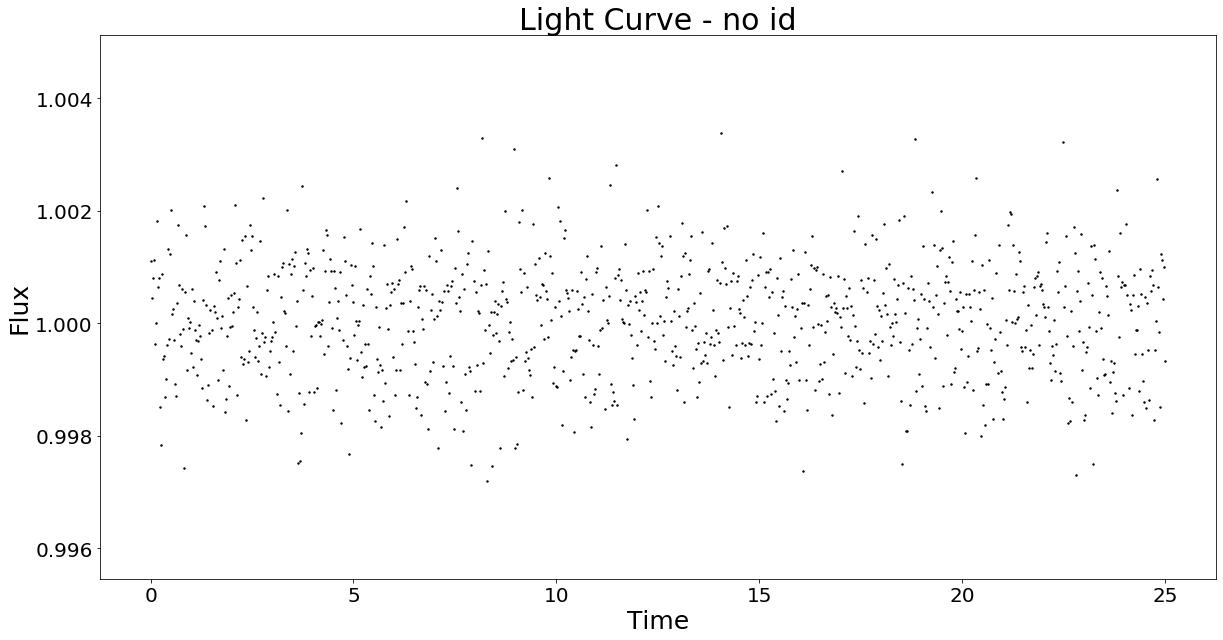

/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


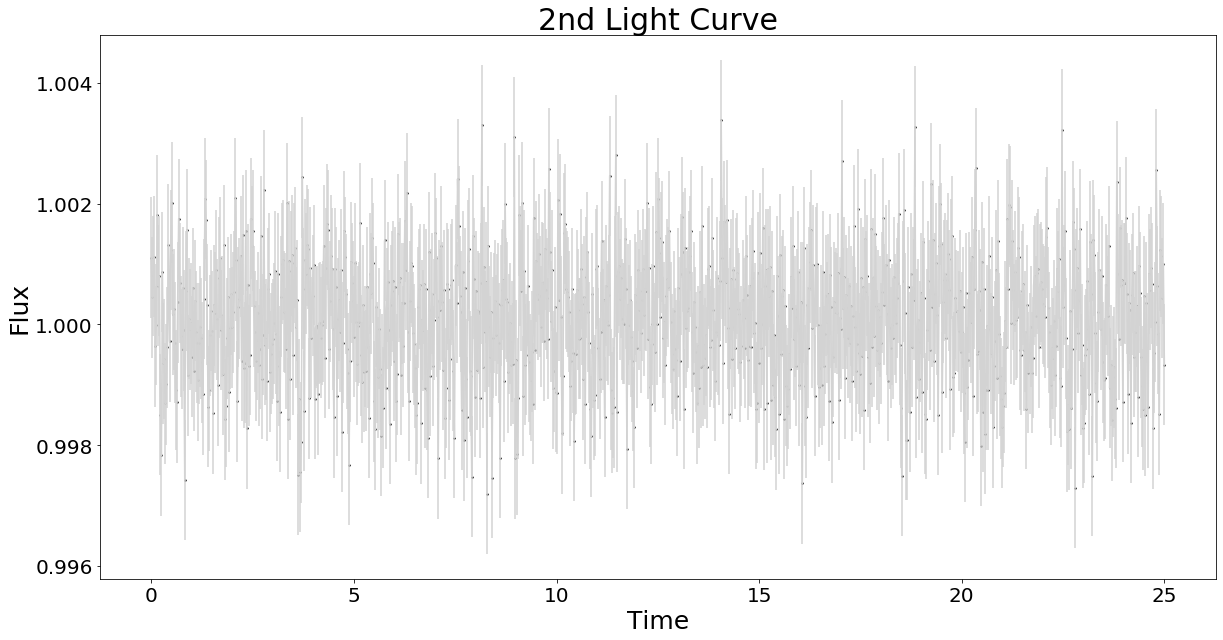

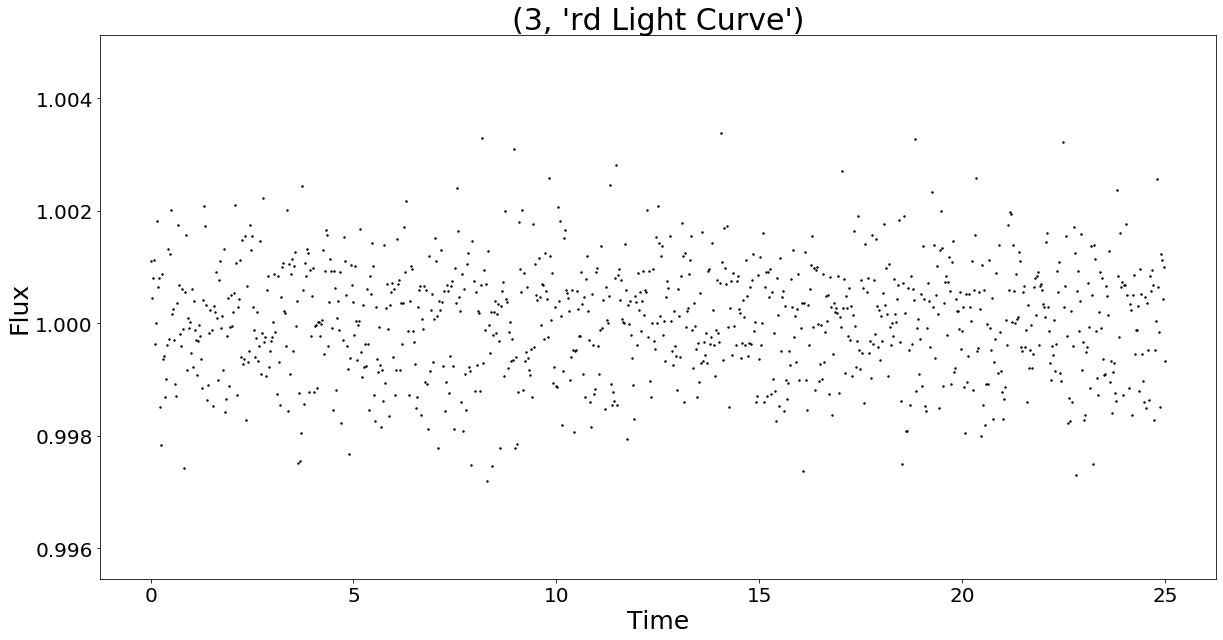

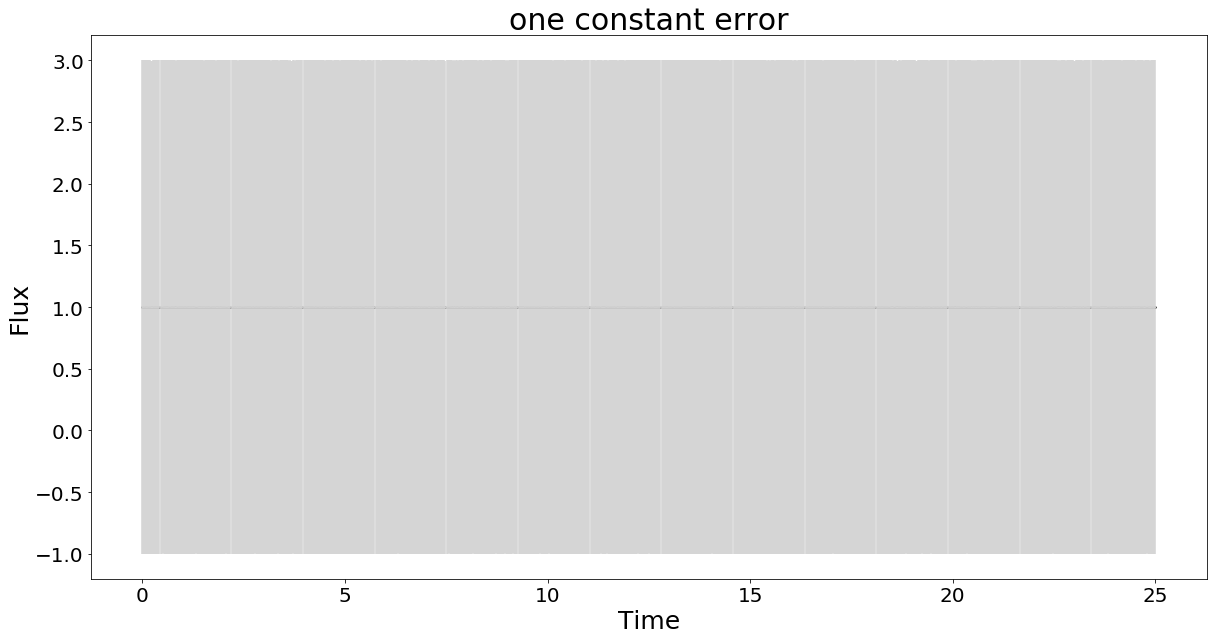

In [52]:
test_fake_data()
test_open_mylcs()
test_plot_lc()
test_flatten_lc()
test_period_grid()
test_duration_grid()
test_bls()
test_kepEBopen()

# Recovery Fraction work

In [5]:
#this was a test - still might need tho
# test_noise = np.logspace(1,10,15)
# plt.scatter(np.linspace(0,14,len(test_noise)),test_noise)
# len(test_noise),test_noise

625 total lc samples
25 different noise levels
25 different periods


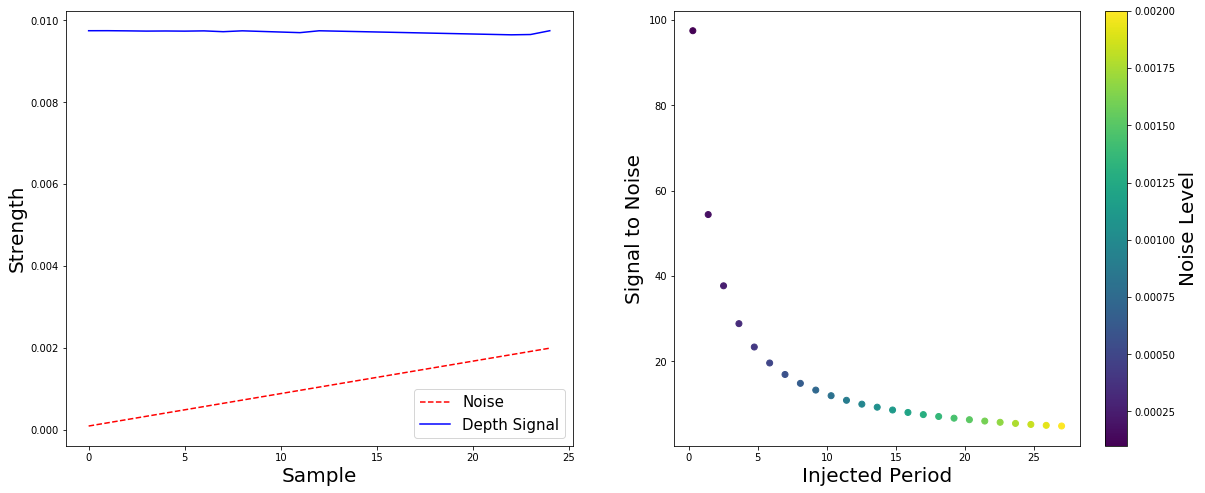

In [6]:
#make sure input params make sense

sample_size = 625 ## MUST be perfect square...for now
num_noise_samples = int(np.sqrt(sample_size)) #doesnt need to be super fine
num_per_samples = int(np.sqrt(sample_size)) #might want to match pgrid
noise_range = (.0001,.002) #min/max (.01,.1)old
pperiod_range = (0.3,27) #min/max
# num_radii_samples = 20
# radii_range = (0.09, 0.11)
# radii = np.linspace(radii_range[0], radii_range[1], num_radii_samples) #using one value 0.1 b/c avg of this and have other params to go over
noise_levels = np.linspace(noise_range[0],noise_range[1],num_noise_samples) #up to 10% noise
planet_periods = np.linspace(pperiod_range[0],pperiod_range[1],num_per_samples)#eventually want to match pipeline
print(sample_size,'total lc samples');print( num_noise_samples,'different noise levels');print(num_per_samples ,'different periods')
tess_time = np.linspace(0,27,19440) #default time from sim_lc()

#####create many single transits with diff periods#####
testflux, testmodel, testparams = one_transit()
 
new_fluxes=[]
for per in planet_periods:
        testparams.per = per #updates planet orbital period
        new_testflux = testmodel.light_curve(testparams); #recalculates light curve
        new_fluxes.append(new_testflux)
        
#####find true signal strenght for sn plot later#######
signals_d=[]
for flux in new_fluxes:
    signal_depth = tdepth(flux)
    signals_d.append(signal_depth)
###plots
f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.plot(noise_levels,color='r',ls='--',label='Noise');
ax1.plot(signals_d,color='b',label='Depth Signal'); 
ax1.legend(fontsize=15);ax1.set_ylabel('Strength',fontsize=20);ax1.set_xlabel('Sample',fontsize=20)

im = ax2.scatter(planet_periods,signals_d/noise_levels,c=noise_levels)
f.colorbar(im,ax=ax2).set_label('Noise Level',fontsize=20)
ax2.set_xlabel('Injected Period',fontsize=20);ax2.set_ylabel('Signal to Noise',fontsize=20);

In [7]:
len(signals_d),len(new_fluxes),len(noise_levels)

(25, 25, 25)

0.3
1.4125
2.525
3.6375
4.75
5.8625
6.9750000000000005
8.0875
9.200000000000001
10.312500000000002
11.425
12.537500000000001
13.650000000000002
14.762500000000001
15.875000000000002
16.9875
18.1
19.212500000000002
20.325000000000003
21.4375
22.55
23.6625
24.775000000000002
25.887500000000003


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:1118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:1118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:1118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

27.0
all the same?: 625 625 625


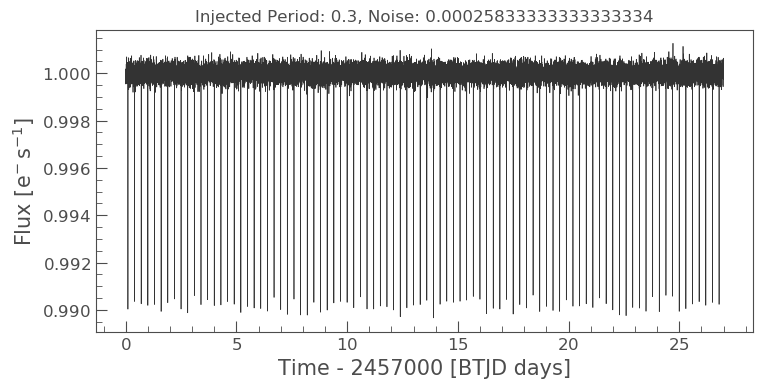

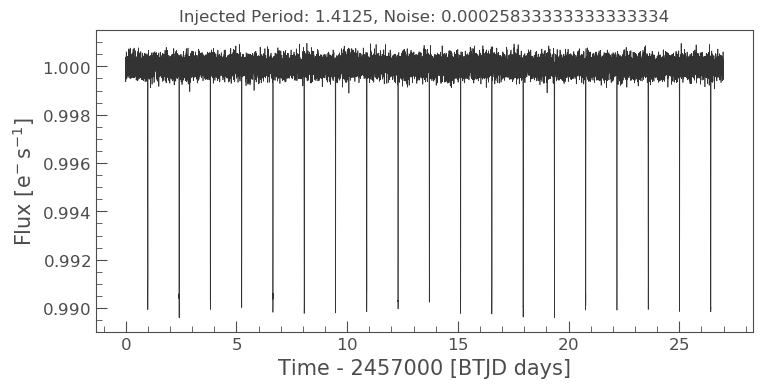

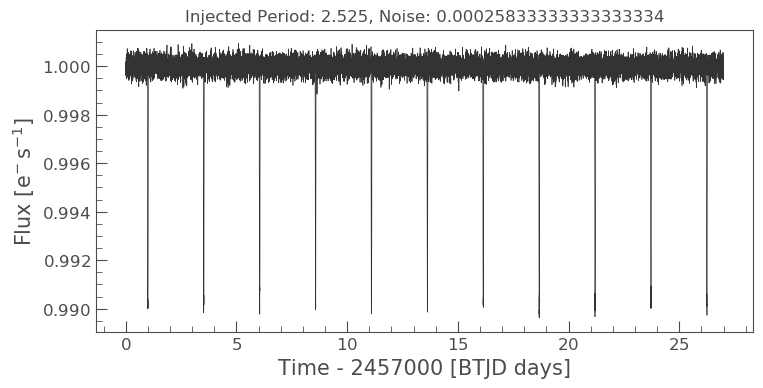

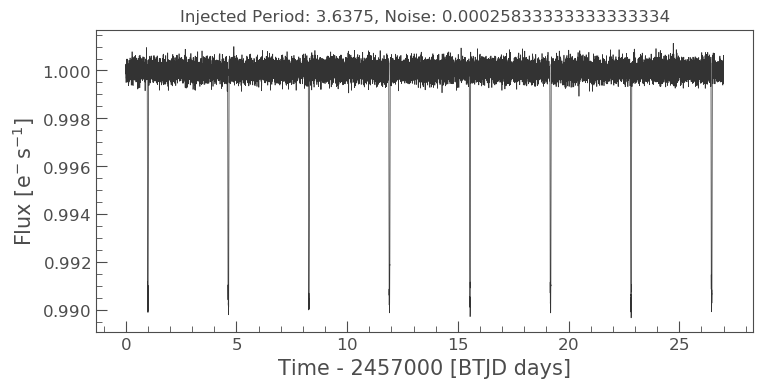

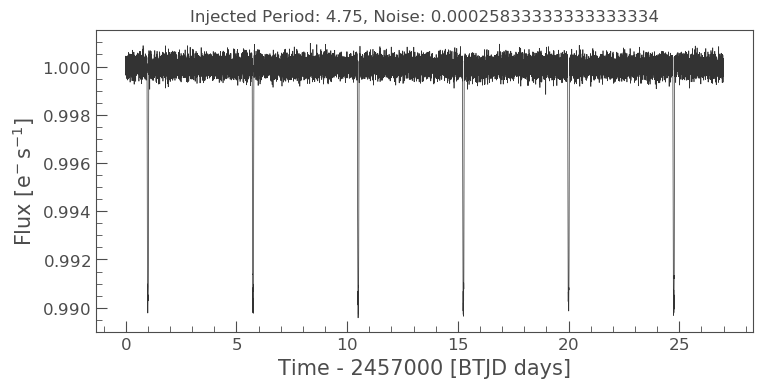

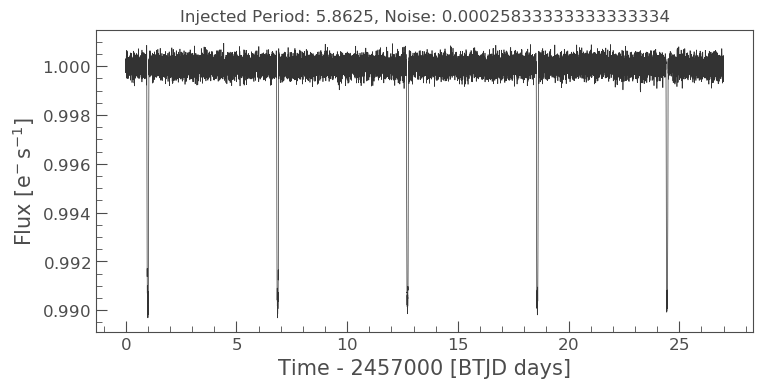

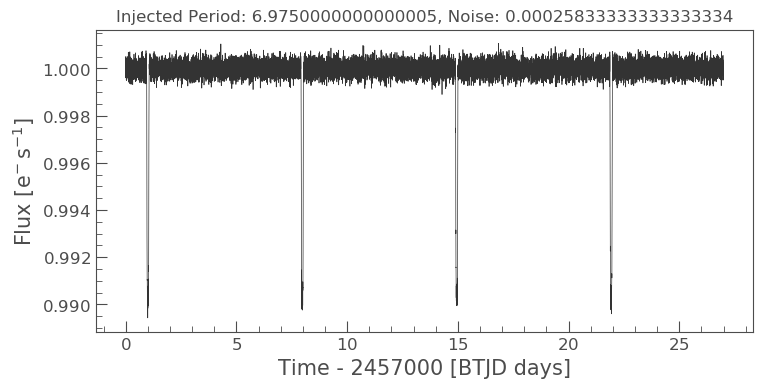

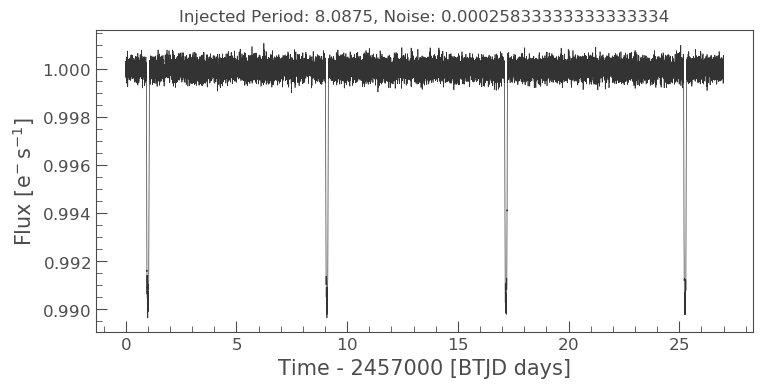

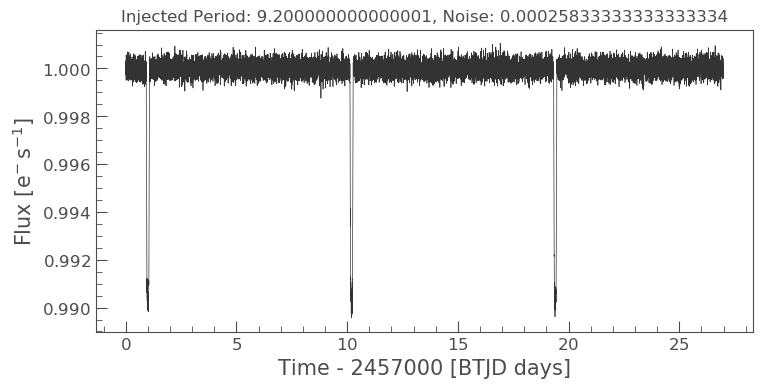

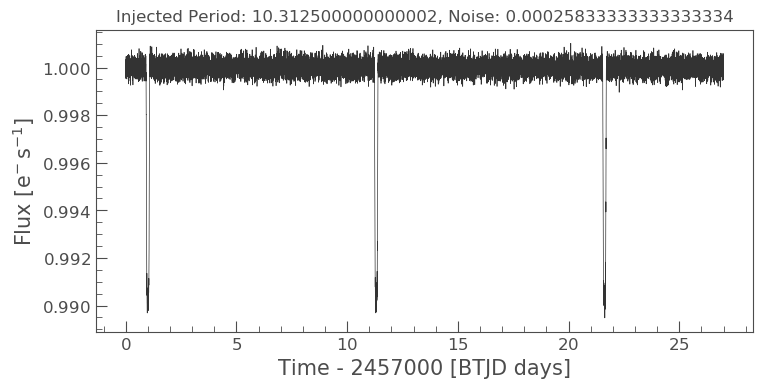

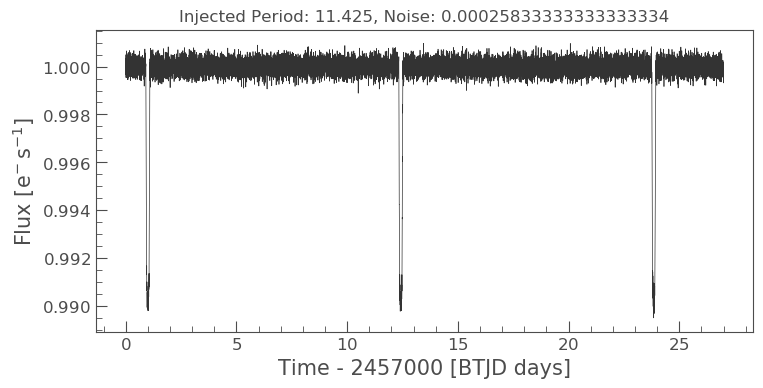

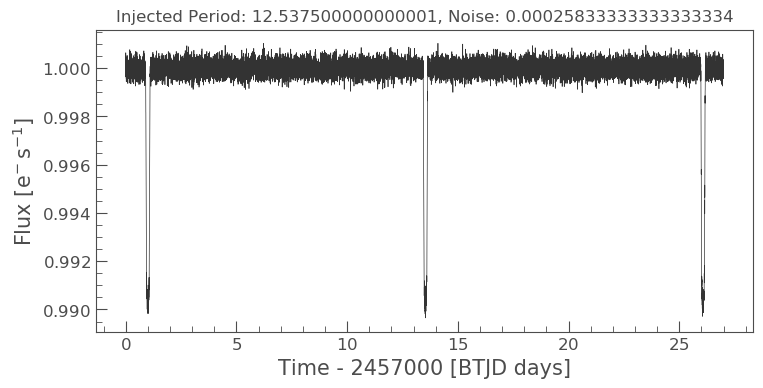

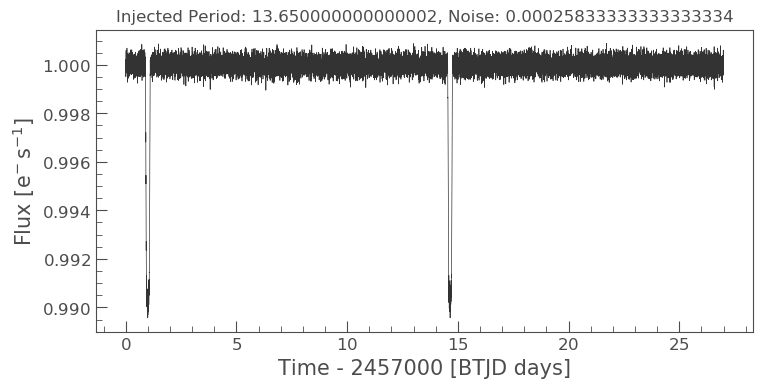

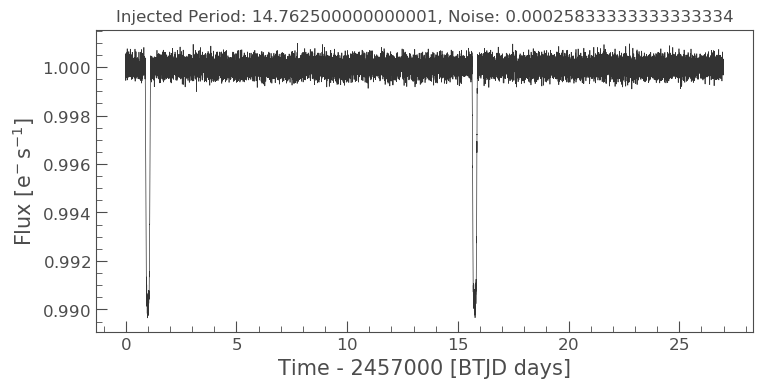

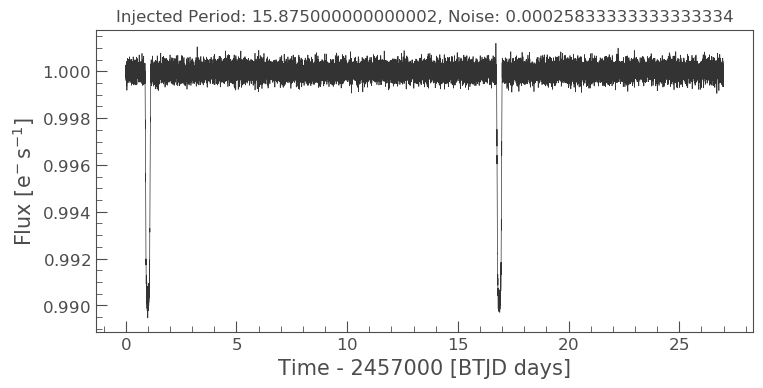

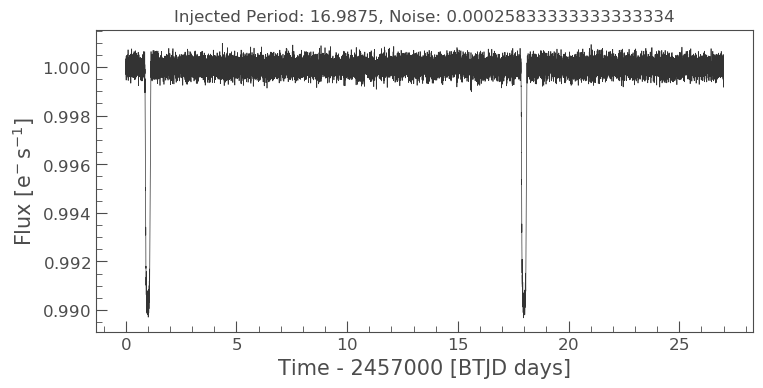

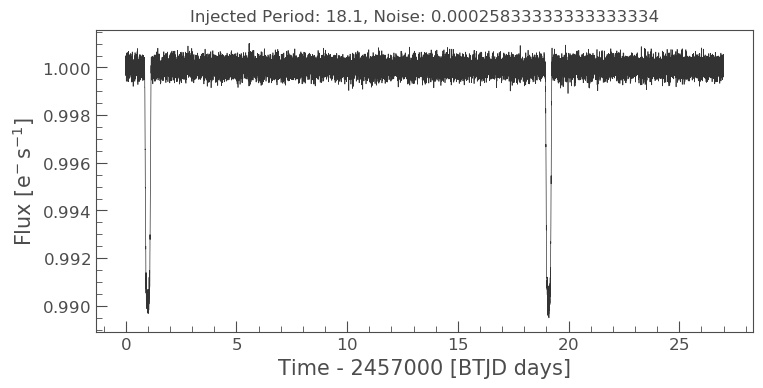

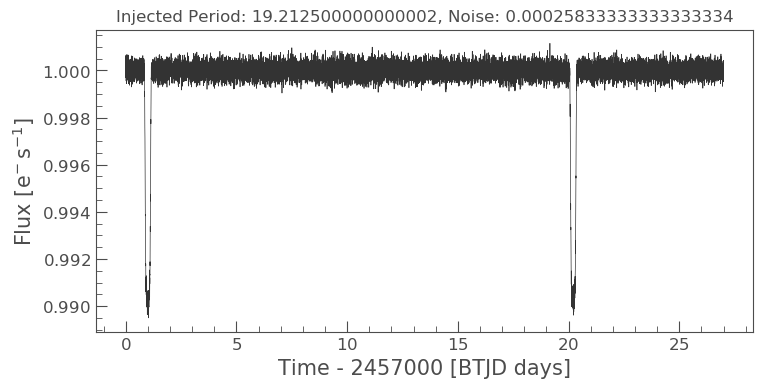

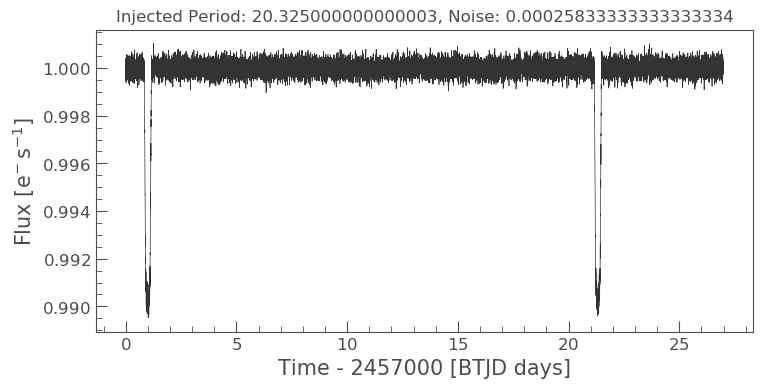

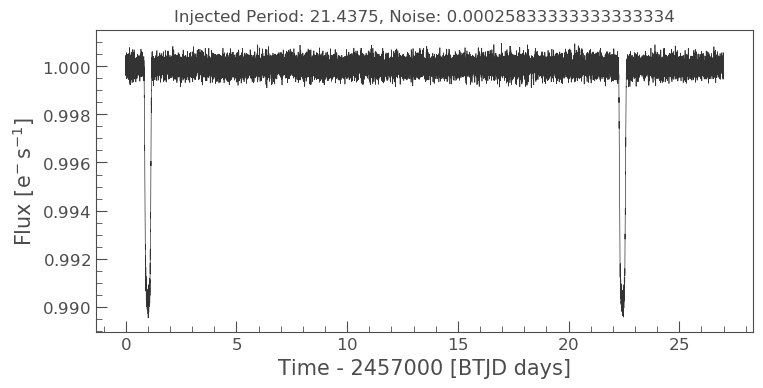

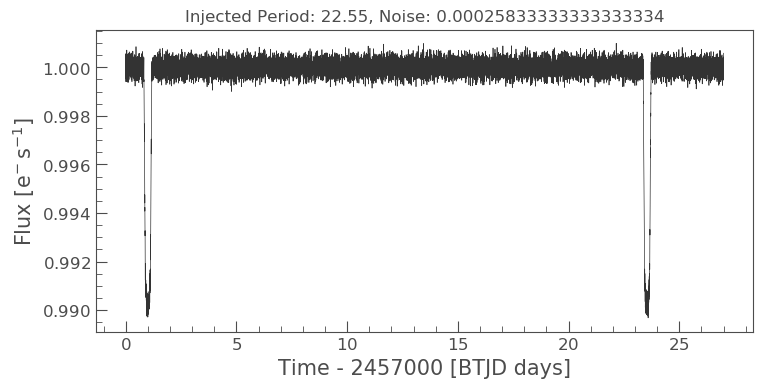

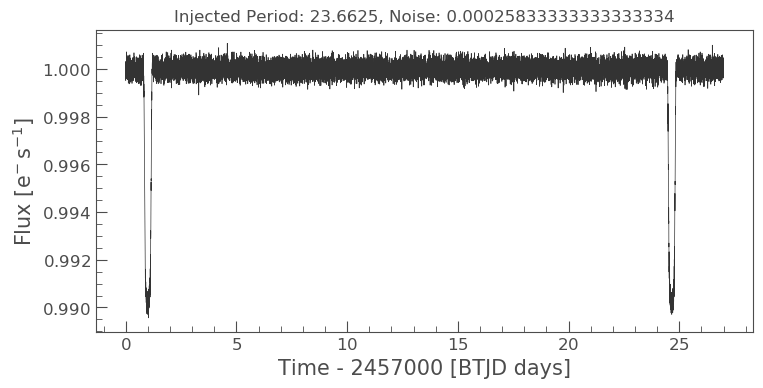

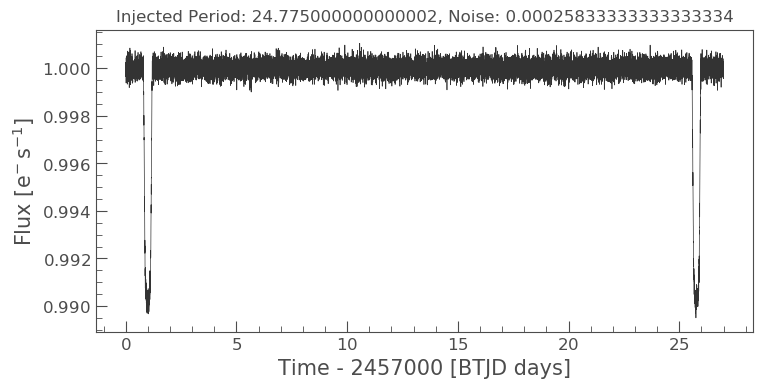

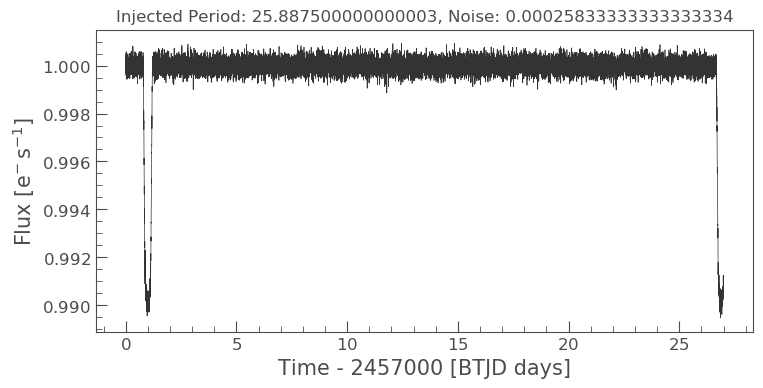

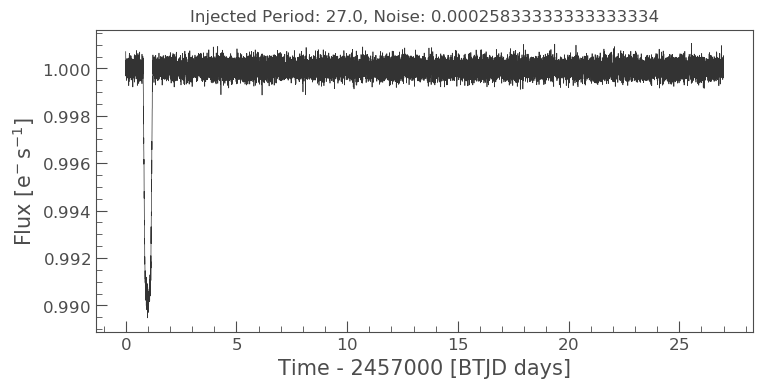

In [8]:

#####turn single transits into TESS sector lcs#####

test_LCs = [];test_Periods =[]; test_Noises =[];test_Depths=[]
for idx,flux in enumerate(new_fluxes):
    per_param = planet_periods[idx]
    print(per_param)
    for count,noise in enumerate(noise_levels):
        test_Periods.append(per_param)
        test_Noises.append(noise)
        test_Depths.append(signals_d[count])
        if count==2: #plot for sanity check
            testlc = sim_lc(flux=flux,time=tess_time,noise_level=noise,plot=True)#noise_level =[n for n in noise_levels])
            plt.title('Injected Period: {}, Noise: {}'.format(per_param, noise))
        else:
            testlc = sim_lc(flux=flux,time=tess_time,noise_level=noise)
        test_LCs.append(testlc)
print('all the same?:',len(test_LCs),len(test_Periods),len(test_Noises))
##continued after 2nd cell of fcns

## NOTE: changed default period_grid & duration_grid from bls fcn here v v v

In [9]:
## with 100 samples only ~3.5 minutes
# with 625 total lcs (25pers*25noises) takes ~20 minutes
#NEED TO reduce sample_size, this takes 6 hours! need total of 1,000 samples max


pgrid = period_grid(start=.3,stop=27,N=25000)
dgrid = duration_grid(start=.01,stop=.29,N=5)
allstats=[];bls_outputs={}
pows=[];pers=[];ds=[];durs=[];tts=[];trupers=[];unc=[];periodograms=[]
# f,ax = plt.subplots(5,1,figsize=(19,15))
count=0
for lc in tqdm(test_LCs):
    imp_t.sleep(1) #time bar to track bls progress on the 10,000 lcs
    time = lc.time
    flux = lc.flux
    fluxerr = lc.flux_err
    t,f,fe = flatten_lc(time,flux,fluxerr)
    periodogram, stats = bls(pgrid,dgrid,t,f,fe)
    
    pows.append(stats[0]);pers.append(stats[1]);ds.append(stats[2]);durs.append(stats[3]);tts.append(stats[4])
    trupers.append(test_Periods[count]); unc.append(test_Noises[count]);periodograms.append(periodogram)
    
    bls_outputs['injected_period']=trupers;bls_outputs['period']=pers;bls_outputs['power']=pows;
    bls_outputs['duration']=durs;bls_outputs['transit_time']=tts
    bls_outputs['depth']=ds;bls_outputs['noise_level']=unc
    count +=1


100%|██████████| 625/625 [1:41:20<00:00,  9.73s/it]


Text(0.5, 0, 'True Period')

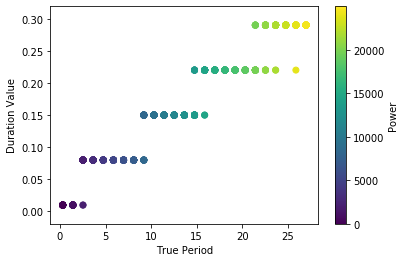

In [66]:
plt.scatter(bls_outputs['injected_period'],bls_outputs['duration'],c= bls_outputs['power'])#x=np.linspace(0,5,len(durs))
plt.colorbar().set_label('Power')
plt.ylabel('Duration Value');plt.xlabel('True Period');
# len(np.linspace(0,5,len(durs))),len(bls_outputs['duration'])
# len(bls_outputs[0])

In [10]:
# for count in range(len(allstats)):
#     print(count,':',allstats[count][0],allstats[count][1])
# #     print(count,':',allstats[count].power)
# # len(allstats),[s.period for s in allstats]
# # allstats[20].period
# 'first',allstats[0][0] #power
# bls_outputs

I dont think this is right b/c the "signal" in this case is from the transit dip...NOT the stars flux - right??
BLUE   ==  GOOD pipeline period
RED   ==   BAD


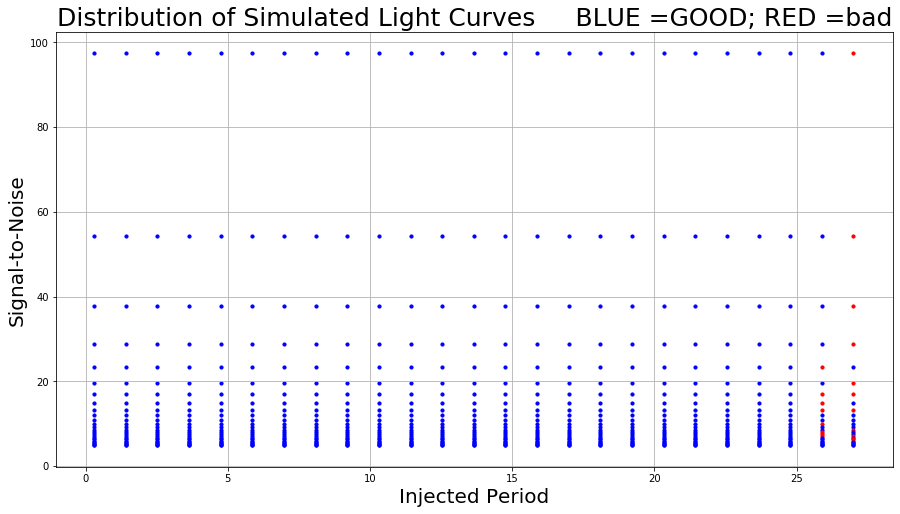

In [11]:
# sample of simulated light curves plot

per_accuracy = np.isclose(bls_outputs['period'],bls_outputs['injected_period'],atol=.5)
colors = ['b'  if i==True else 'r' for i in per_accuracy]

plt.figure(figsize=(15,8))
count=0
for i in range(sample_size):
    depth = test_Depths[i] # flux = np.mean(test_LCs[i].flux)#NOOOOOOOO - do depth/noise
    noise = bls_outputs['noise_level'][i] 
    sn = depth/noise#flux/noise #NOOOOOOOO - do depth/noise
    plt.scatter(test_Periods[i],sn,s=10,c=colors[i])#allstats
    plt.xlabel('Injected Period',fontsize=20)
    plt.ylabel('Signal-to-Noise',fontsize=20)
    plt.title('Distribution of Simulated Light Curves     BLUE =GOOD; RED =bad',fontsize=25)
    plt.grid('on')
#     plt.axhline(100)

print('I dont think this is right b/c the "signal" in this case is from the transit dip...NOT the stars flux - right??')
print('BLUE   ==  GOOD pipeline period')
print('RED   ==   BAD')

In [12]:
#try to get recovery fraction data for plotting
mydata = {'injected_period': test_Periods,'sn':sn,'accuracy':per_accuracy}
mydf = pd.DataFrame(data=mydata)
for row in mydf:
    print(row,'next')

injected_period next
sn next
accuracy next


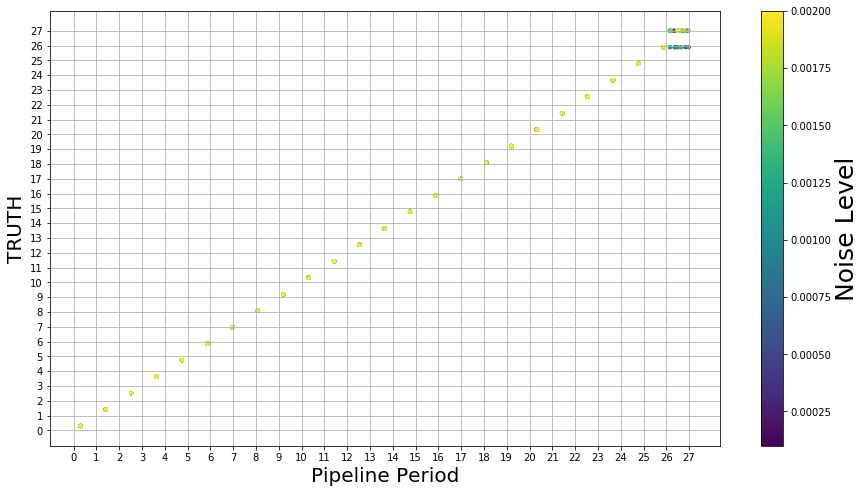

In [13]:
# recovery fraction plot--failed attempt-this is something else

plt.figure(figsize=(15,8))
plt.scatter(bls_outputs['period'],bls_outputs['injected_period'],s=10,c=bls_outputs['noise_level'])
plt.xlabel('Pipeline Period',fontsize=20);plt.ylabel('TRUTH',fontsize=20)
# plt.scatter(np.linspace(0,max(planet_periods),len(planet_periods)),planet_periods,color='r',s=10)
plt.xticks(np.arange(0,28,1));plt.yticks(np.arange(0,28,1))
plt.colorbar().set_label('Noise Level',fontsize=25);
plt.grid('on');
# plt.title('Beware the different sized points----many overlaid, see separate plots by noise further down');
# plt.xlim(0,5)

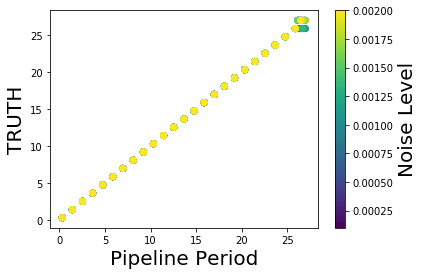

In [14]:
# len(per_accuracy==True), len(bls_outputs['period'])
# len(np.where(per_accuracy==True)[0])
fs = 20 #fontsize
plt.scatter(bls_outputs['period'],bls_outputs['injected_period'],c=bls_outputs['noise_level'])
plt.colorbar().set_label('Noise Level',fontsize=fs);plt.xlabel('Pipeline Period',fontsize=fs);plt.ylabel('TRUTH',fontsize=fs);
#lower noise better obviously; need to see plots by noise tho

In [15]:
bls_outputs['accuracy']=per_accuracy
df = pd.DataFrame(data=bls_outputs)
pd.set_option('display.max_rows', df.shape[0]+1) #to show all rows
df[['period','injected_period','noise_level','accuracy']]

period  injected_period  noise_level  accuracy
0     0.300000           0.3000     0.000100      True
1     0.300000           0.3000     0.000179      True
2     0.300000           0.3000     0.000258      True
3     0.300000           0.3000     0.000337      True
4     0.300000           0.3000     0.000417      True
5     0.300000           0.3000     0.000496      True
6     0.300000           0.3000     0.000575      True
7     0.300000           0.3000     0.000654      True
8     0.300000           0.3000     0.000733      True
9     0.300000           0.3000     0.000812      True
10    0.300000           0.3000     0.000892      True
11    0.300000           0.3000     0.000971      True
12    0.300000           0.3000     0.001050      True
13    0.300000           0.3000     0.001129      True
14    0.300000           0.3000     0.001208      True
15    0.300000           0.3000     0.001288      True
16    0.300000           0.3000     0.001367      True
17    0.300000           0.3000     0.001446      True
18    0.300000           0.3000     0.001525      True
19    0.300000           0.3000     0.001604      True
20    0.300000           0.3000     0.001683      True
21    0.300000           0.3000     0.001762      True
22    0.300000           0.3000     0.001842      True
23    0.300000           0.3000     0.001921      True
24    0.300000           0.3000     0.002000      True
25    1.412901           1.4125     0.000100      True
26    1.412901           1.4125     0.000179      True
27    1.412901           1.4125     0.000258      True
28    1.412901           1.4125     0.000337      True
29    1.412901           1.4125     0.000417      True
30    1.412901           1.4125     0.000496      True
31    1.412901           1.4125     0.000575      True
32    1.412901           1.4125     0.000654      True
33    1.412901           1.4125     0.000733      True
34    1.412901           1.4125     0.000812      True
35    1.412901           1.4125     0.000892      True
36    1.412901           1.4125     0.000971      True
37    1.412901           1.4125     0.001050      True
38    1.412901           1.4125     0.001129      True
39    1.412901           1.4125     0.001208      True
40    1.412901           1.4125     0.001288      True
41    1.412901           1.4125     0.001367      True
42    1.412901           1.4125     0.001446      True
43    1.412901           1.4125     0.001525      True
44    1.412901           1.4125     0.001604      True
45    1.412901           1.4125     0.001683      True
46    1.412901           1.4125     0.001762      True
47    1.412901           1.4125     0.001842      True
48    1.412901           1.4125     0.001921      True
49    1.412901           1.4125     0.002000      True
50    2.527937           2.5250     0.000100      True
51    2.527937           2.5250     0.000179      True
52    2.527937           2.5250     0.000258      True
53    2.527937           2.5250     0.000337      True
54    2.527937           2.5250     0.000417      True
55    2.527937           2.5250     0.000496      True
56    2.527937           2.5250     0.000575      True
57    2.525801           2.5250     0.000654      True
58    2.527937           2.5250     0.000733      True
59    2.524733           2.5250     0.000812      True
60    2.523665           2.5250     0.000892      True
61    2.524733           2.5250     0.000971      True
62    2.525801           2.5250     0.001050      True
63    2.524733           2.5250     0.001129      True
64    2.527937           2.5250     0.001208      True
65    2.524733           2.5250     0.001288      True
66    2.524733           2.5250     0.001367      True
67    2.525801           2.5250     0.001446      True
68    2.524733           2.5250     0.001525      True
69    2.525801           2.5250     0.001604      True
70    2.524733           2.5250     0.001683      True
71    2.524733           2.5250     0.001762    

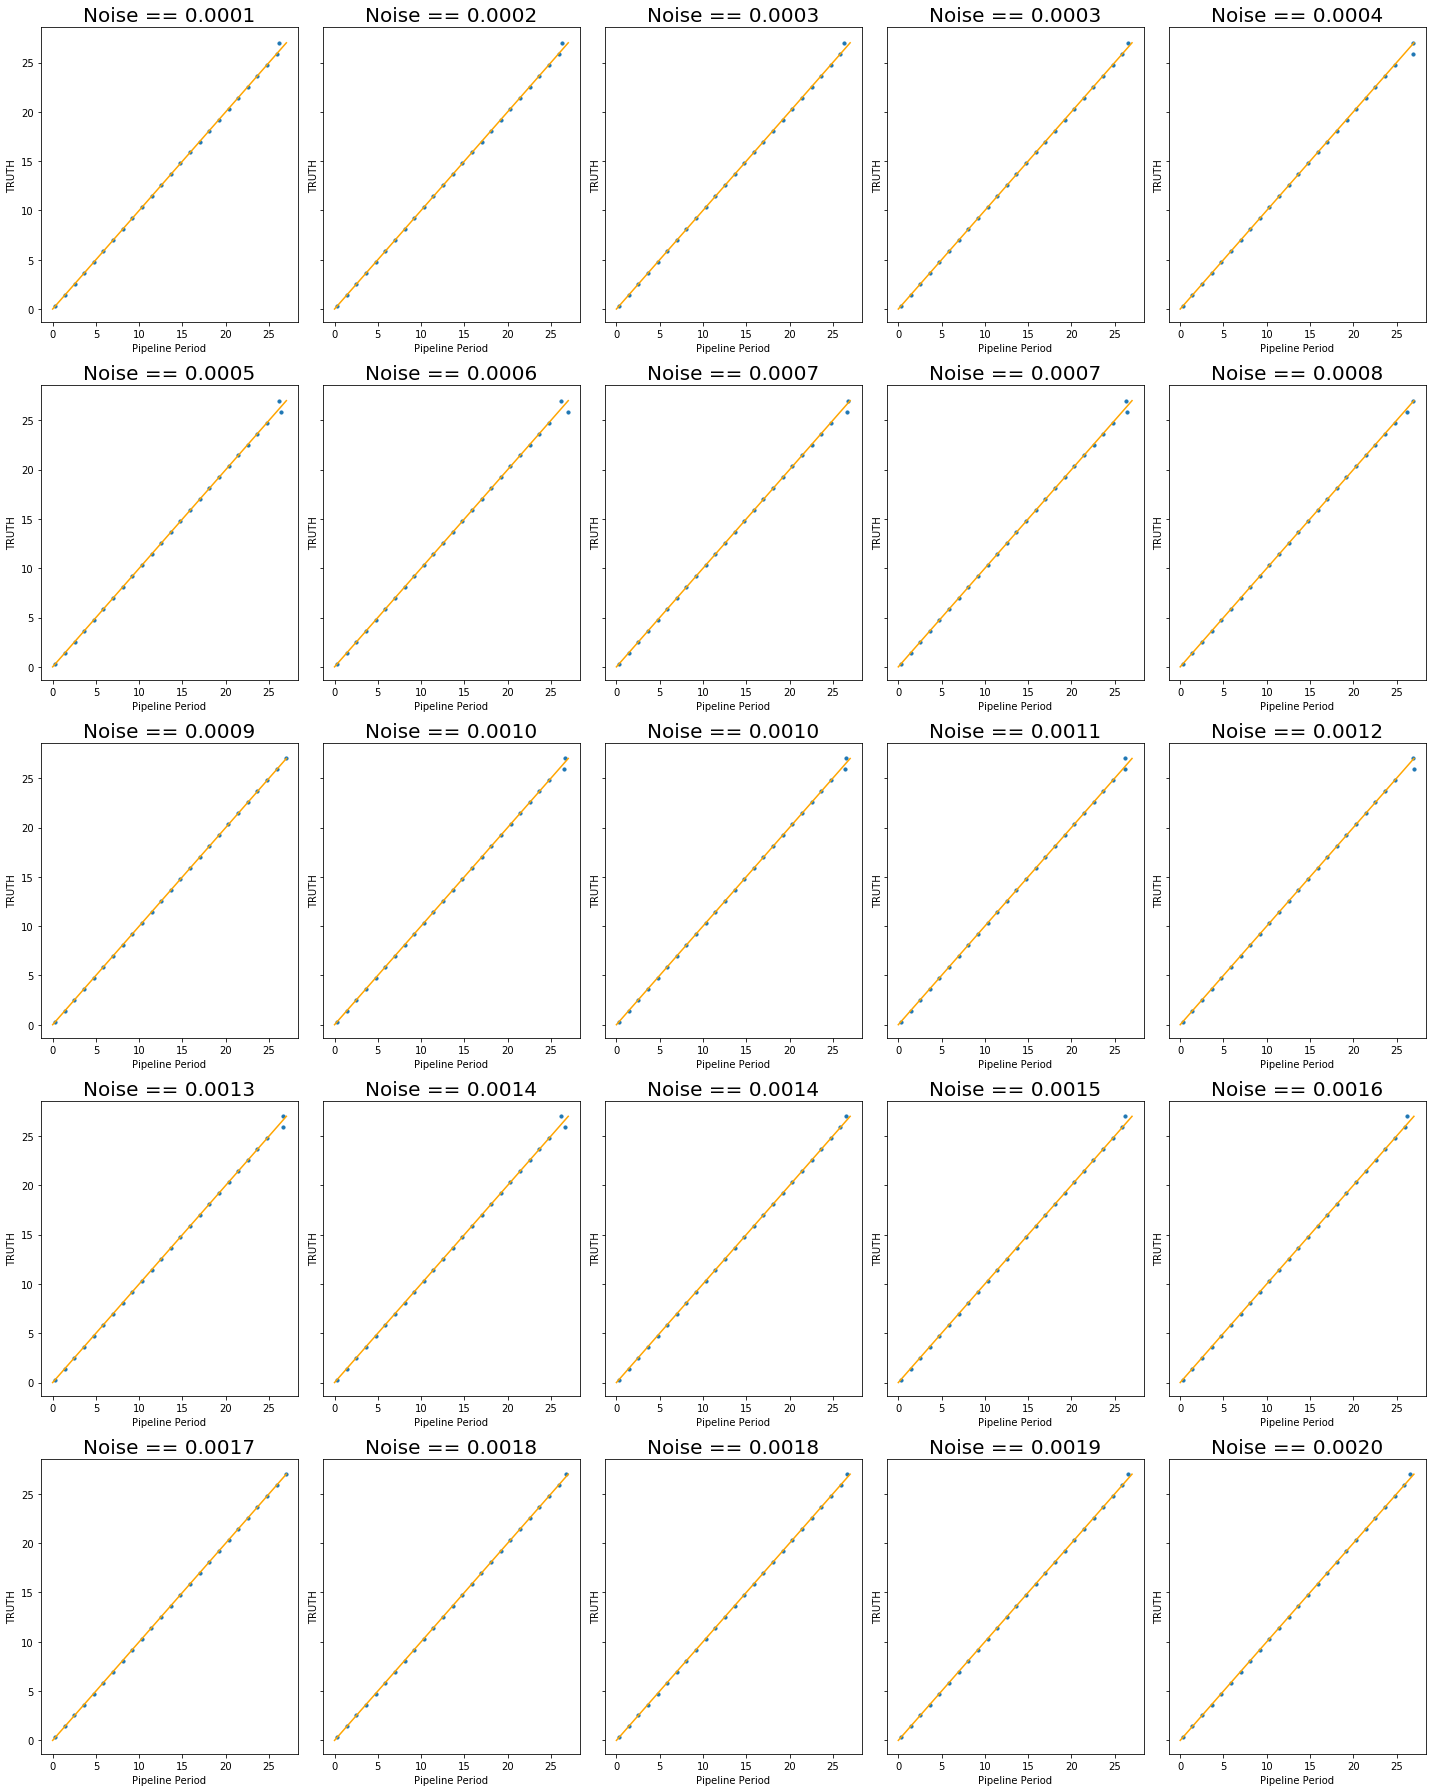

In [16]:
# noise_levels
f, ax = plt.subplots(5,5,figsize=(20,25),sharey=True)#,sharey=True,sharex=True)
# for count,i in enumerate(noise_levels):
#     noise_used = bls_outputs['noise_level'][count]
#     if noise_used == i:
arow = list(itertools.repeat([0,1,2,3,4], 5))
rows = list(itertools.chain.from_iterable(arow))
for count,i in enumerate(rows):
    shortdf = df[df['noise_level']==noise_levels[count]]
    if 0<=count<=4:
        r=0
    elif 4<count<=9:
        r=1
    elif 9<count<=14:
        r=2
    elif 14<count<=19:
        r=3
    else:
        r=4
    ax[r,i].scatter(shortdf['period'],shortdf['injected_period'],s=10)
    ax[r,i].plot(np.arange(0,28,1),np.arange(0,28,1),color='orange')
    ax[r,i].set_xlabel('Pipeline Period');ax[r,i].set_ylabel('TRUTH')
    ax[r,i].set_title('Noise == {}'.format('%.4f' %noise_levels[count]),fontsize=20)
plt.tight_layout()

# look at some of the periodograms

In [17]:
# plt.figure(figsize=(20,12))
# plt.plot(periodogram.period,periodogram.power)
# plt.xlabel('Period',fontsize=20)
# plt.ylabel('Power',fontsize=20)
# plt.axvline(bls_outputs['injected_period'][-1],ls='--',color='orange',label='injected period')
# plt.axvline(bls_outputs['period'][-1],ls='--',color='g',label='bls period')
# plt.legend(fontsize=20)
# plt.title('Injected Period: {}, Noise Level: {}'.format(bls_outputs['injected_period'][-1],bls_outputs['noise_level'][-1]),fontsize=30);


Seems periodogram only changes when Injected Period changes


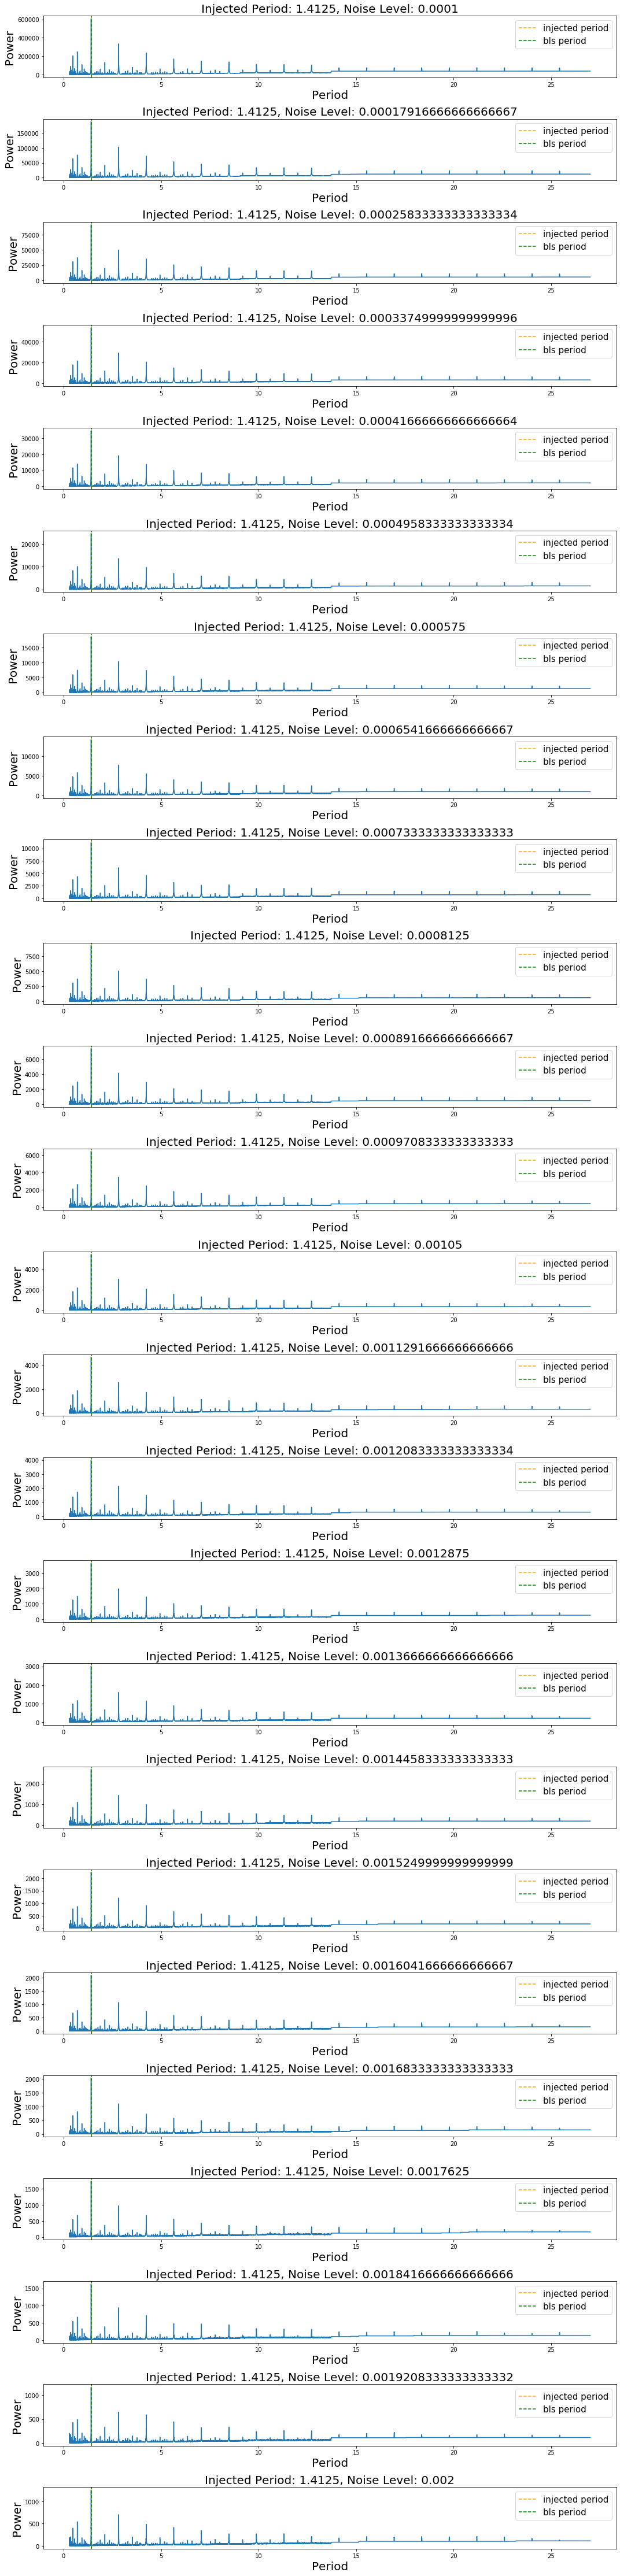

In [18]:
N = range(25,50) #use for indices for bls data; max index is len(sample_size)

num_plots = len(N) if min(N)==0 else N[-1]-N[0]+1
f, ax =plt.subplots(num_plots,1,figsize=(15,62))
for i,idx in enumerate(N): #i for axes, idx for index of arrays
    ax[i].plot(periodograms[idx].period,periodograms[idx].power)
    ax[i].set_xlabel('Period',fontsize=20); ax[i].set_ylabel('Power',fontsize=20)
    ax[i].axvline(bls_outputs['injected_period'][idx],ls='--',color='orange',label='injected period')
    ax[i].axvline(bls_outputs['period'][idx],ls='--',color='g',label='bls period')
    ax[i].legend(fontsize=15)
    ax[i].set_title('Injected Period: {}, Noise Level: {}'.format(bls_outputs['injected_period'][idx],bls_outputs['noise_level'][idx]),fontsize=20);
plt.tight_layout()
print('Seems periodogram only changes when Injected Period changes')

Text(0.5, 1.0, 'Injected Period: 0.3 Noise Level: 0.0001')

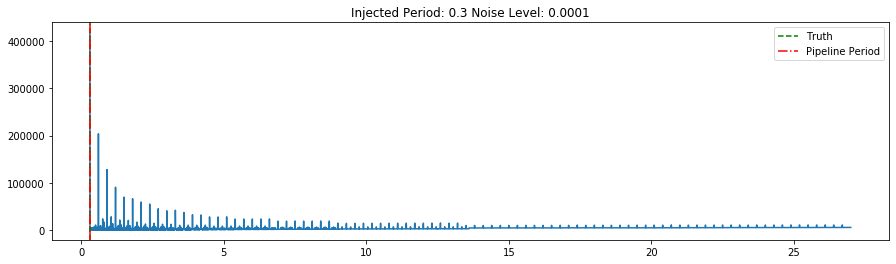

In [19]:
#one periodogram

idx = 0 #max_index = len(periodograms) ie sample_size ==625
plt.figure(figsize=(15,4))
power = periodograms[idx].power
period = periodograms[idx].period
plt.plot(period,power)
plt.axvline(bls_outputs['injected_period'][idx],ls='--', color='g',label='Truth')
plt.axvline(bls_outputs['period'][idx],ls='-.',color='r',label='Pipeline Period')
plt.legend()
plt.title('Injected Period: {} Noise Level: {}'.format(bls_outputs['injected_period'][idx] ,bls_outputs['noise_level'][idx]))

/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:1118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:1118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:1118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

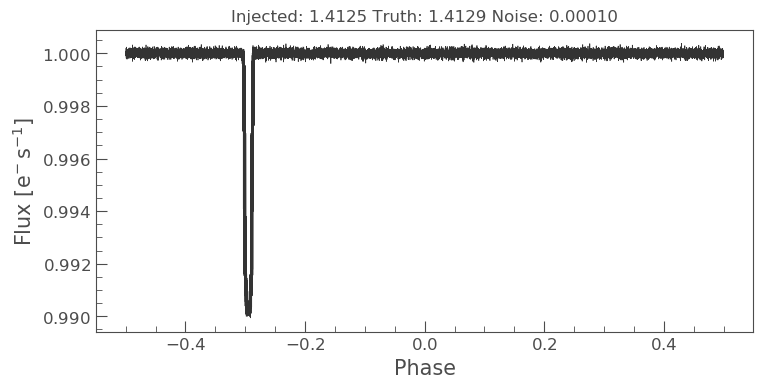

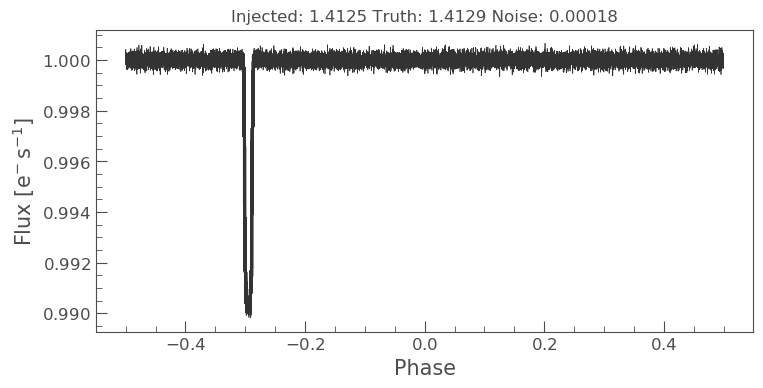

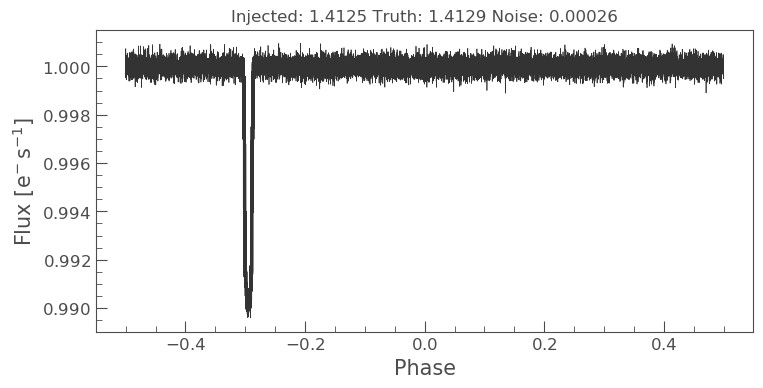

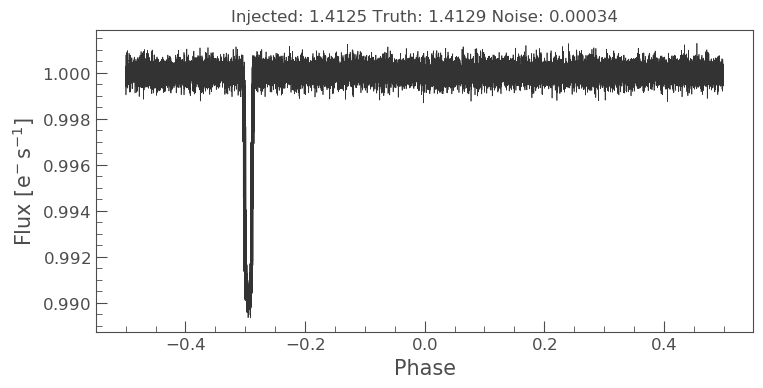

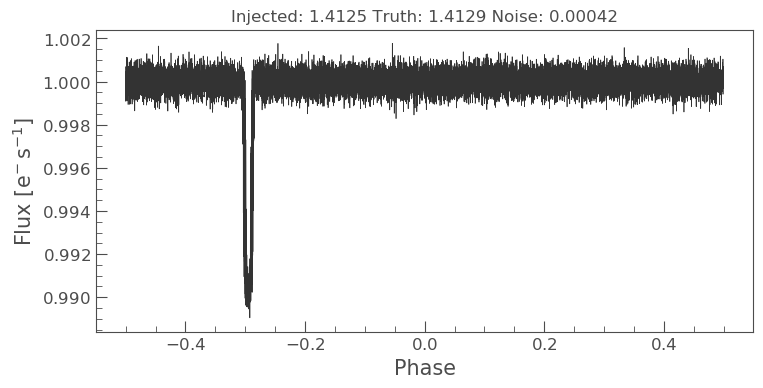

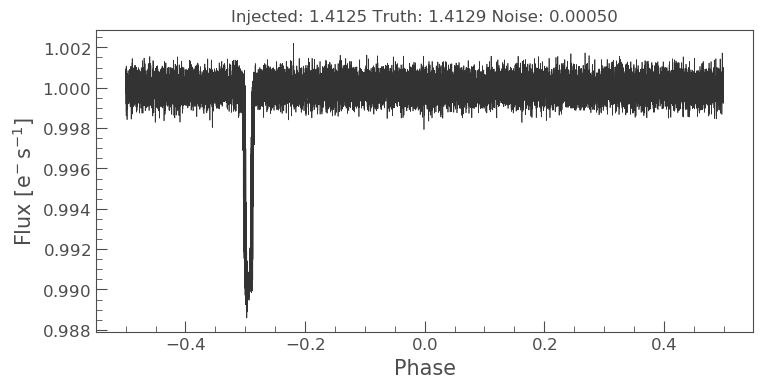

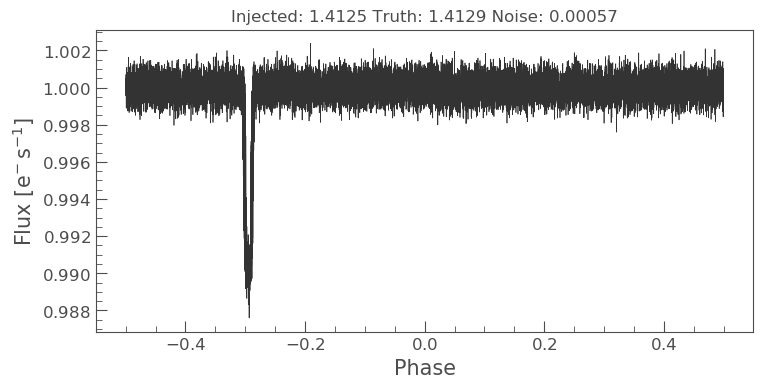

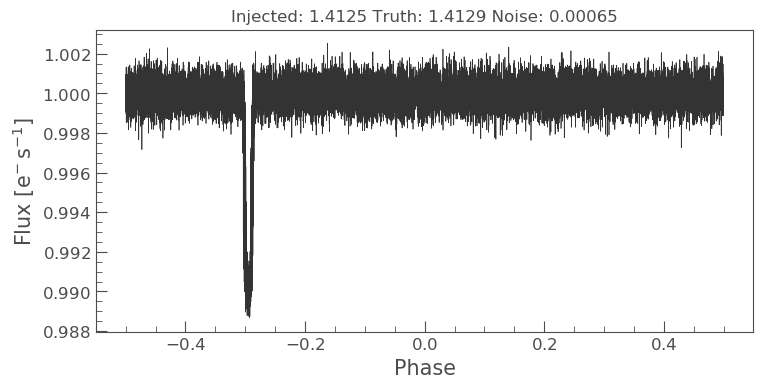

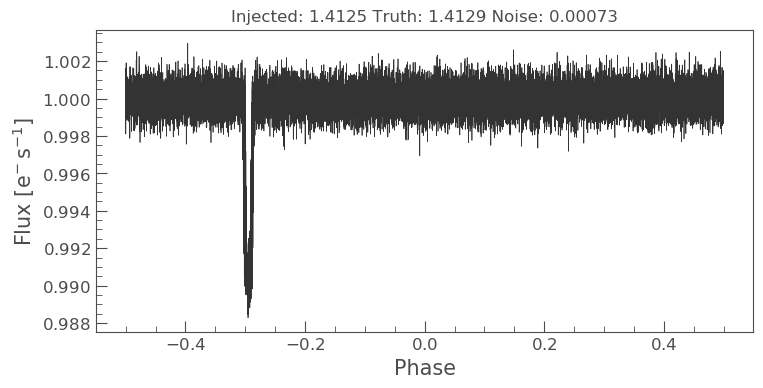

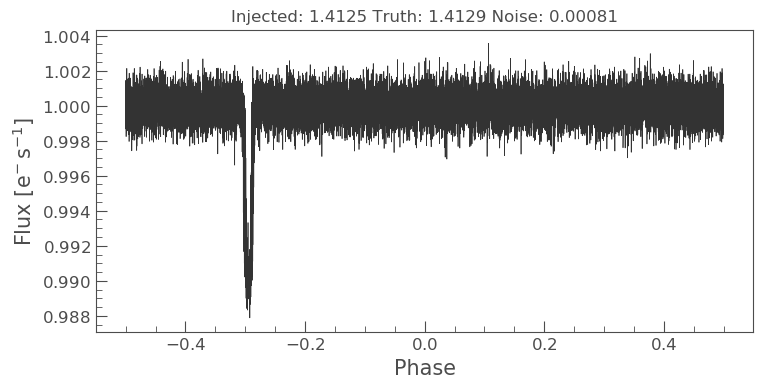

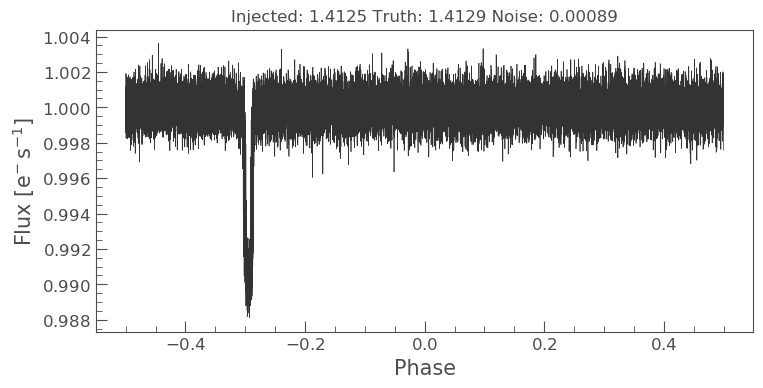

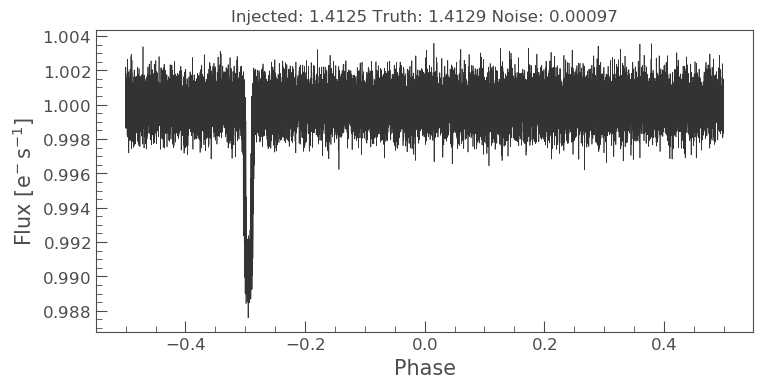

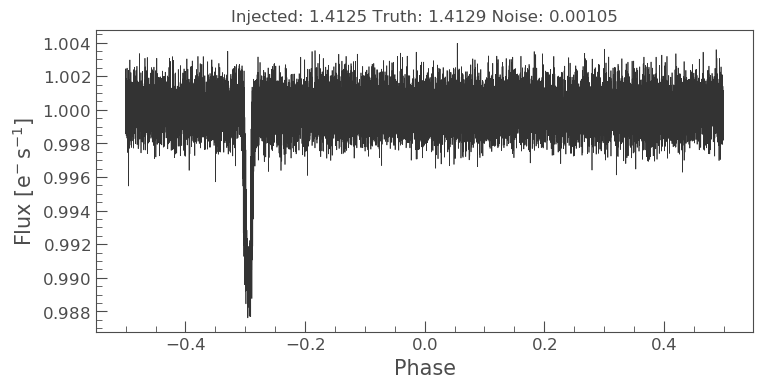

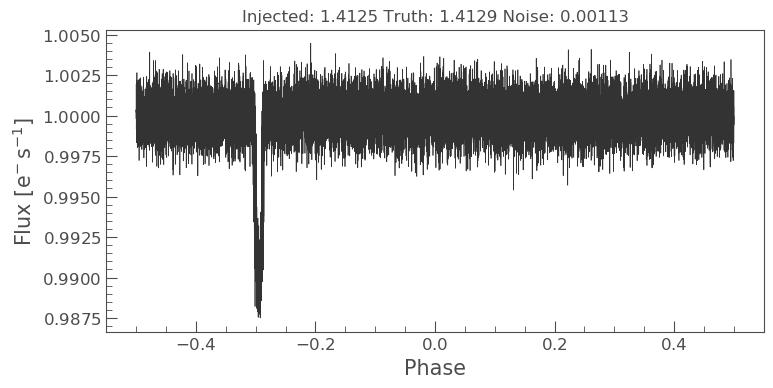

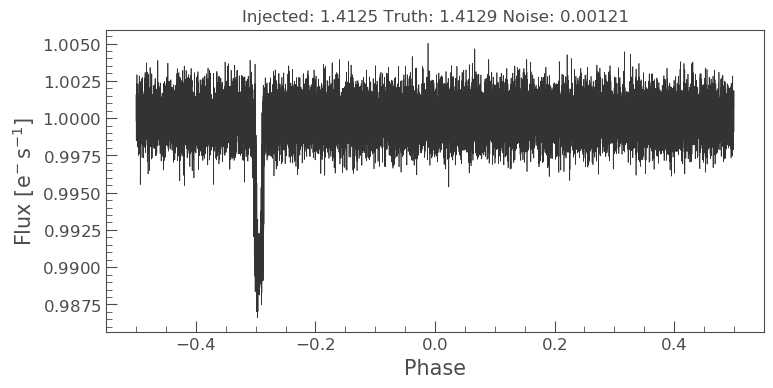

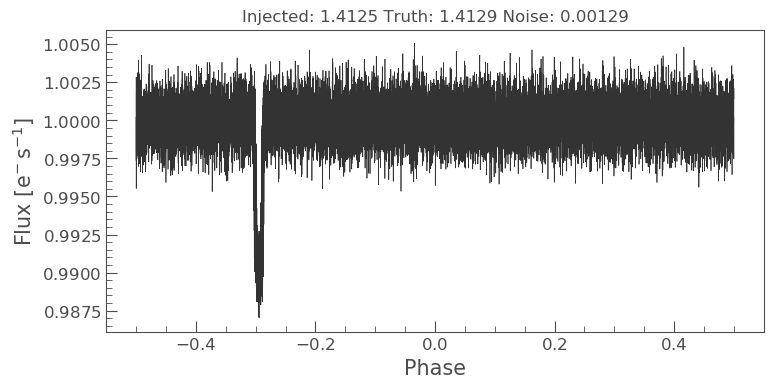

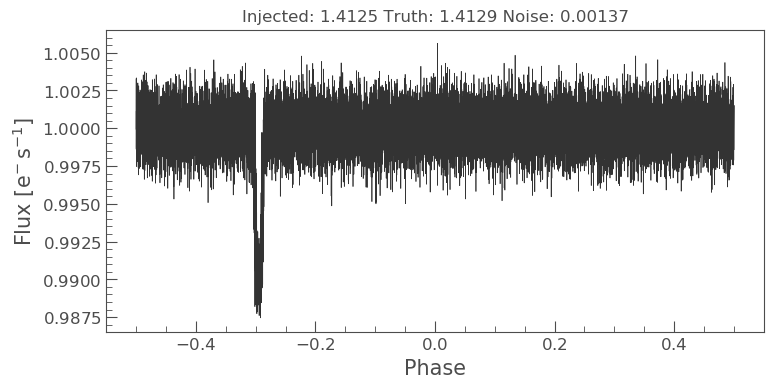

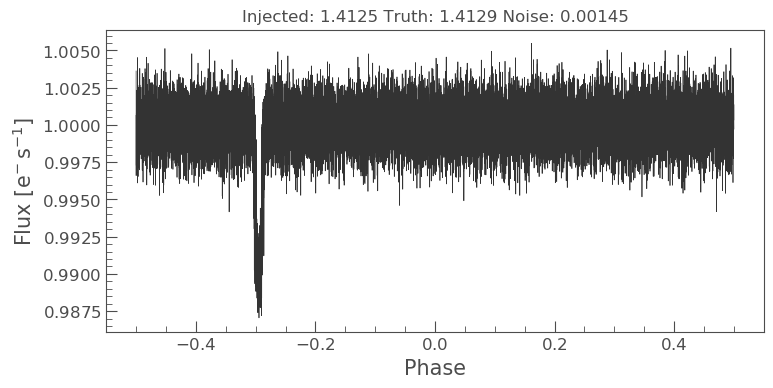

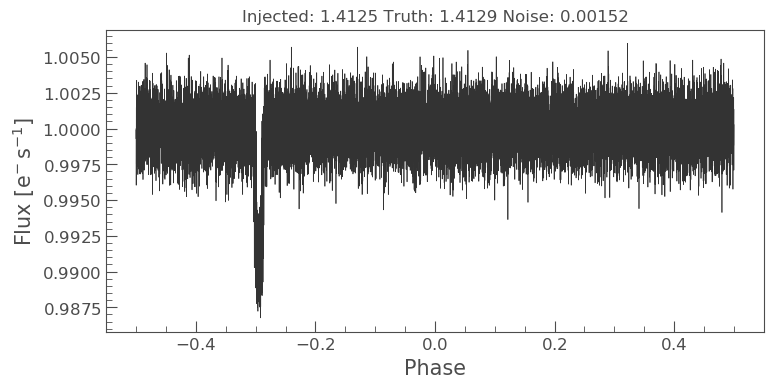

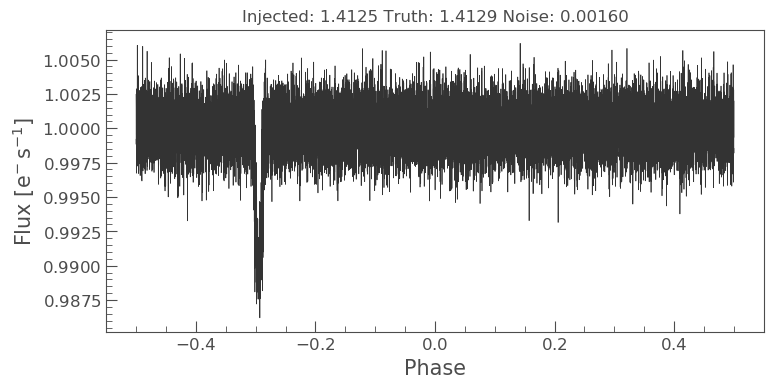

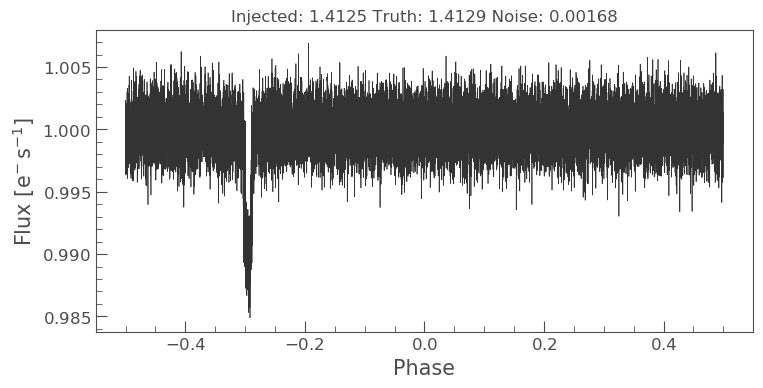

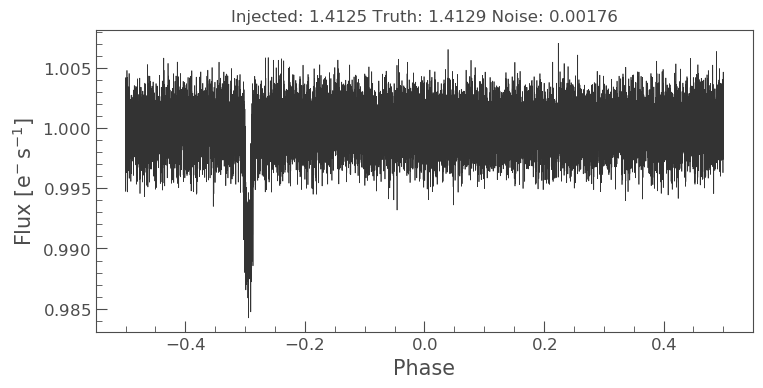

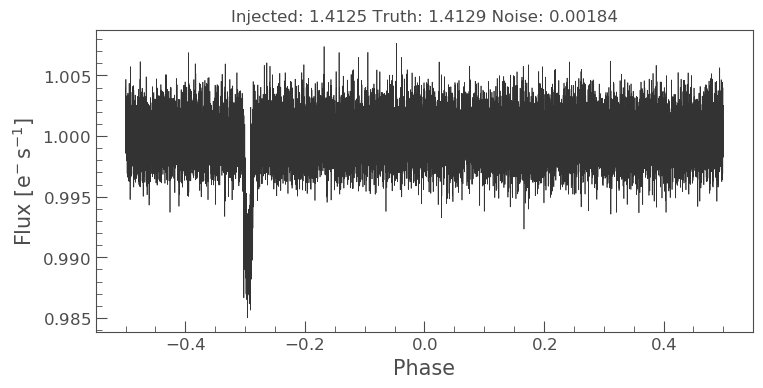

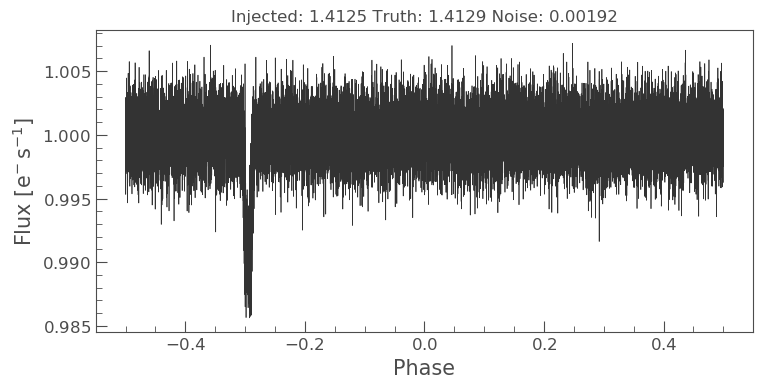

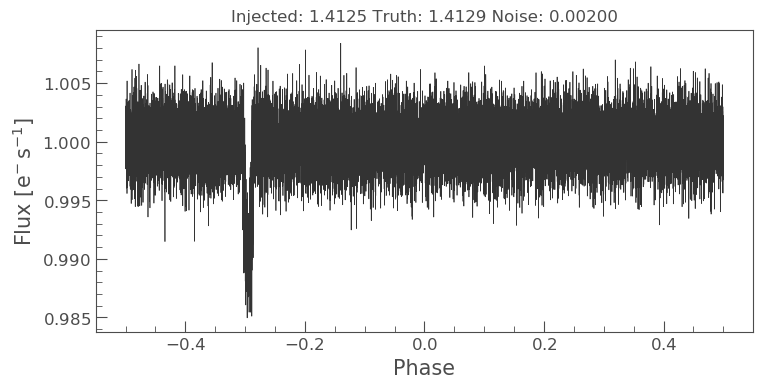

In [20]:
# phase folding

for idx in range(25,50): #dont do >25 at a time
    lc = test_LCs[idx]
    per = bls_outputs['period'][idx]
    fold = lc.fold(period=per)#,t0=1.)
    fold.plot()
    plt.title('Injected: {} Truth: {} Noise: {}'.format(bls_outputs['injected_period'][idx],'%.4f' %bls_outputs['period'][idx],'%.5f' %bls_outputs['noise_level'][idx]))
    

# Test on Kepler EBs

In [68]:
# load results data
kep_table = pd.read_csv('data/KeplerEBs/KeplerEB_bls_stats2.csv')
kep_table

KIC  period_truth  period_bls  power_bls  depth_bls  dur_bls  tt_bls
0     9702641      0.503178    1.761082       1368   0.083878     0.08   0.216
1     5376552      0.503819    2.015277       1606   0.159650     0.08   0.041
2     9813678      0.505079    0.505064        192   0.009787     0.08   0.263
3     5128972      0.505324    1.263375        902   0.038771     0.08   0.244
4     5088735      0.507501    0.507200        194   0.001049     0.22   0.396
5     6353203      0.508504    0.508268        195   0.001996     0.29   0.257
6     3448245      0.513490    2.567455       2123   0.197223     0.08   1.440
7    11774383      0.520227    0.520017        206   0.002229     0.29   0.145
8    11560447      0.527679    6.332305       5648   0.129951     0.08   4.398
9     4458989      0.529854    4.238942       3688   0.058124     0.15   3.250
10    6044543      0.532086    2.660374       2210   0.182963     0.08   1.478
11   10586874      0.535487    1.071127        722   0.192188     0.08   0.202
12    8074045      0.536393    2.145578       1728   0.189553     0.08   2.066
13    6042031      0.537104    0.537105        222   0.000042     0.08   0.296
14   12267718      0.545051    1.362703        995   0.117091     0.08   0.149
15    5390351      0.547454    0.821205        488   0.061037     0.08   0.071
16    7506164      0.558013    1.115985        764   0.027282     0.15   0.975
17    6213131      0.561416    1.684183       1296   0.119580     0.08   0.870
18    4660997      0.562560    2.250246       1826   0.298139     0.08   1.635
19    9030447      0.566698    0.567011        250   0.000042     0.29   0.147
20    7431703      0.572526    7.443070       6688   0.163621     0.08   0.329
21    8616873      0.576079    2.880391       2416   0.004124     0.08   1.439
22    7037319      0.578110    1.734381       1343   0.035347     0.15   0.591
23    8587078      0.584147    0.584099        266   0.037764     0.15   0.136
24    9644680      0.585941    1.757878       1365   0.161235     0.08   0.756
25    9142964      0.589253    2.357050       1926   0.053854     0.08   0.329
26    9084778      0.592244    1.184339        828   0.000509     0.29   0.924
27    3954227      0.594276    1.188612        832   0.087493     0.08   0.502
28    5792093      0.600588    1.801668       1406   0.015132     0.15   1.370
29   11703960      0.604417    0.604392        285   0.046819     0.15   0.380
30    9514070      0.607256    0.607596        288   0.081684     0.15   0.517
31    7769072      0.608863    6.088792       5420   0.000674     0.08   4.783
32    9706078      0.613561    1.840118       1442   0.000405     0.22   0.376
33    7584826      0.622309    1.866819       1467   0.127873     0.08   1.237
34   10844279      0.623413    0.311748         11   0.101275     0.22   0.212
35    8971432      0.624387    1.873227       1473   0.018033     0.08   0.258
36   11193447      0.625884    0.626821        306   0.004476     0.29   0.483
37   11904038      0.632220    0.632161        311   0.002061     0.22   0.376
38    4037163      0.635444    0.635365        314   0.047524     0.08   0.381
39    5716763      0.640661    0.640706        319   0.000136     0.08   0.391
40   11144556      0.642980    1.928765       1525   0.068907     0.15   1.229
41    3853673      0.643796    3.218961       2733   0.000212     0.08   3.126
42   10007533      0.648064    1.620101       1236   0.079626     0.15   1.526
43    5820209      0.656087    1.968283       1562   0.034883     0.15   0.951
44   10226388      0.660657    0.991024        647   0.096166     0.15   0.888
45   10275747      0.661748    1.985371       1578   0.207804     0.15   0.691
46    4936680      0.666227    0.333109         31   0.168611     0.22   0.229
47    3127873      0.671526    1.678843       1291   0.085521     0.15   1.131
48    4571536      0.676715    0.303204          3   0.000031     0.29   0.145
49    7051984      0.678133    1.356294        989   0.00002

In [146]:
print('       Expected         Output')
print('Min:',min(kep_table['period_truth']),'    ',min(kep_table['period_bls']))
print('Max:',max(kep_table['period_truth']),'    ',max(kep_table['period_bls']))



       Expected         Output
Min: 0.5031783      0.30106804272170884
Max: 14.8544154      26.144497779911198


In [147]:
tol = 1e-1
# keb_accuracy = np.isclose(kep_table['period_truth'],kep_table['period_bls'],atol=tol)
# np.isclose isnt good for <1.
lessthanone = kep_table[kep_table['period_bls']<1.]
lessboth = lessthanone[lessthanone['period_truth']<1.]
greaterthanone = kep_table[kep_table['period_bls']>1.]
greaterboth = greaterthanone[greaterthanone['period_truth']>1.]
# print(len(lessboth),len(greaterboth))
keb_accuracy_less = np.isclose(lessboth['period_truth'],lessboth['period_bls'],atol=tol)
keb_accuracy_bigger = np.isclose(greaterboth['period_truth'],greaterboth['period_bls'],atol=tol)




trues = len(keb_accuracy_less[keb_accuracy_less==True])
total_tf = len(keb_accuracy_less)
falses = total_tf - trues
print('%.2f'%((trues/total_tf)*100), '% or',trues,'out of',total_tf,'accurate to within', tol)
print('this accuracy for comparsions of values LESS THAN 1.')
print('----BUT np.close() isnt best for <1.----')
trues_bigger = len(keb_accuracy_bigger[keb_accuracy_bigger==True])
total_tf_bigger = len(keb_accuracy_bigger)
falses_bigger = total_tf_bigger - trues_bigger
print('%.2f'%((trues_bigger/total_tf_bigger)*100), '% or',trues_bigger,'out of',total_tf_bigger,'accurate to within', tol)
print('and that is the accuracy for comparisons of values GREATER THAN 1.')

74.07 % or 40 out of 54 accurate to within 0.1
this accuracy for comparsions of values LESS THAN 1.
----BUT np.close() isnt best for <1.----
66.84 % or 264 out of 395 accurate to within 0.1
and that is the accuracy for comparisons of values GREATER THAN 1.


In [140]:
max(greaterboth['period_bls'][keb_accuracy_bigger])

14.854218168726751

(0.3, 16)

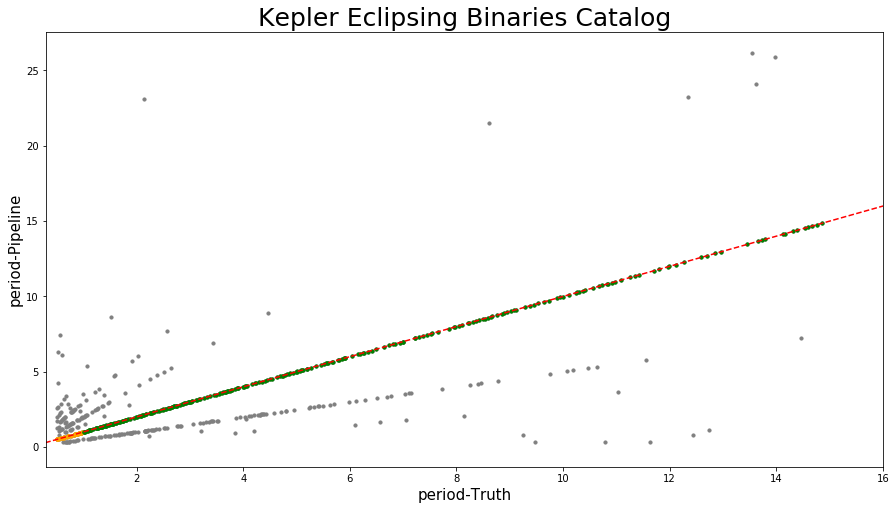

In [139]:
#plot accuracy
maxpt = max(kep_table['period_truth']) if max(kep_table['period_truth'])>max(kep_table['period_bls']) else max(kep_table['period_bls'])
one2one = np.linspace(0,maxpt,len(kep_table))

plt.figure(figsize=(15,8))
plt.plot(one2one,one2one,ls='--',color='r')
plt.scatter(kep_table['period_truth'],kep_table['period_bls'],s=10,color='grey')
plt.scatter(lessboth['period_truth'][keb_accuracy_less],lessboth['period_bls'][keb_accuracy_less],s=10,color='orange')
plt.scatter(greaterboth['period_truth'][keb_accuracy_bigger],greaterboth['period_bls'][keb_accuracy_bigger],s=10,color='g')
plt.title('Kepler Eclipsing Binaries Catalog',fontsize=25)
plt.xlabel('period-Truth',fontsize=15);plt.ylabel('period-Pipeline',fontsize=15);
plt.xlim(0.3,16)#helps with this run

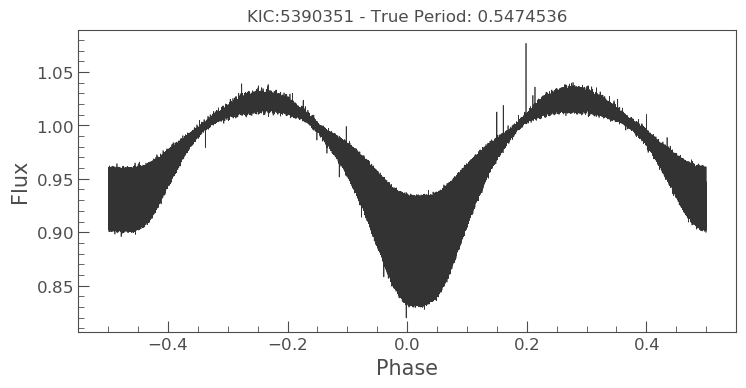

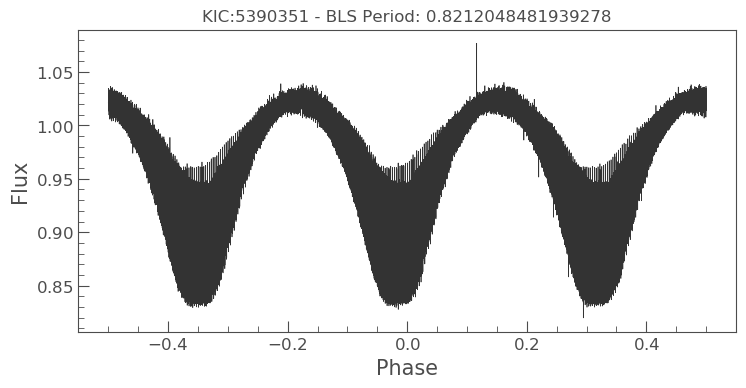

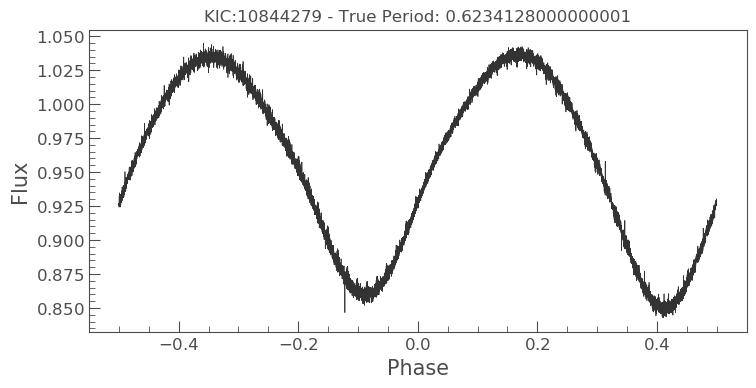

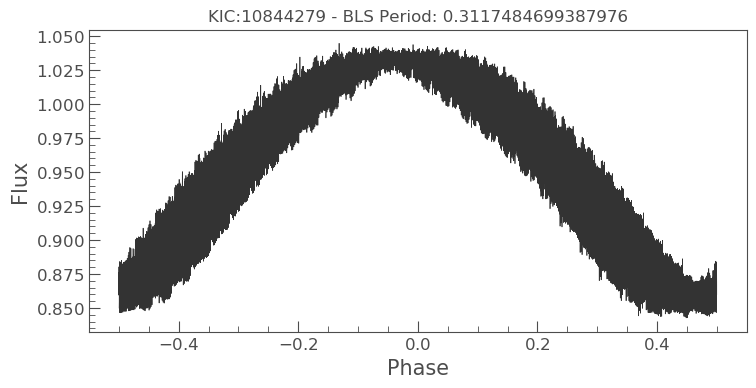

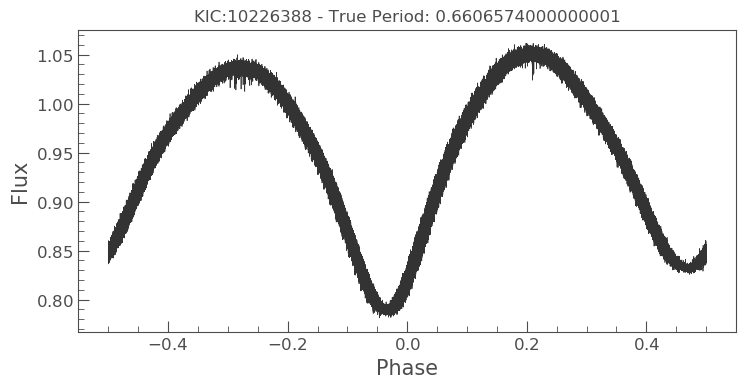

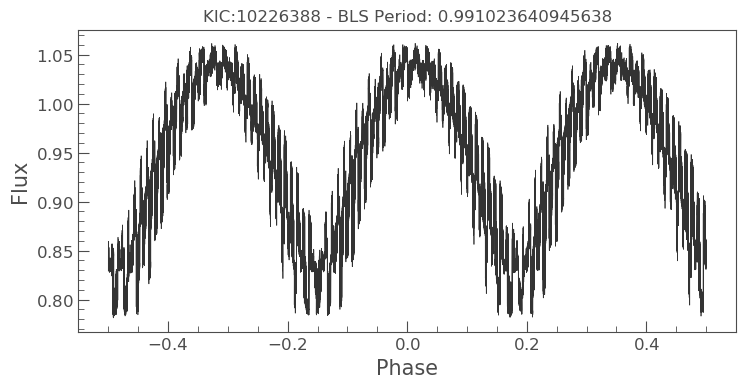

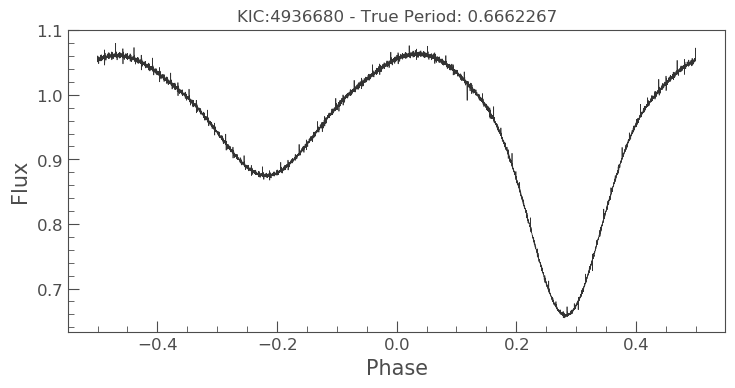

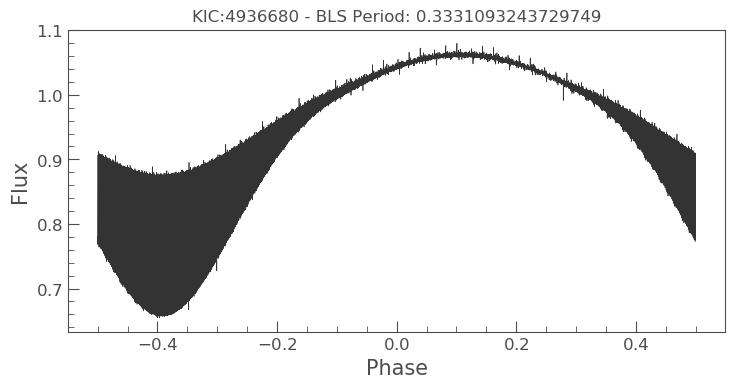

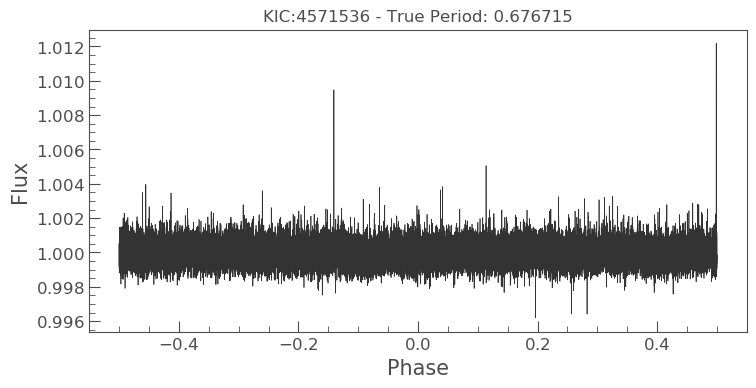

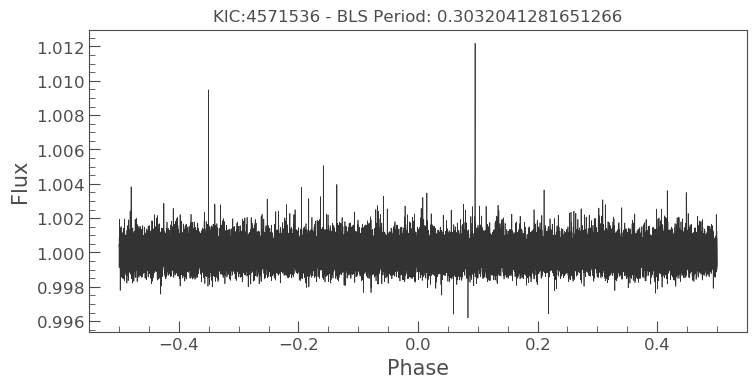

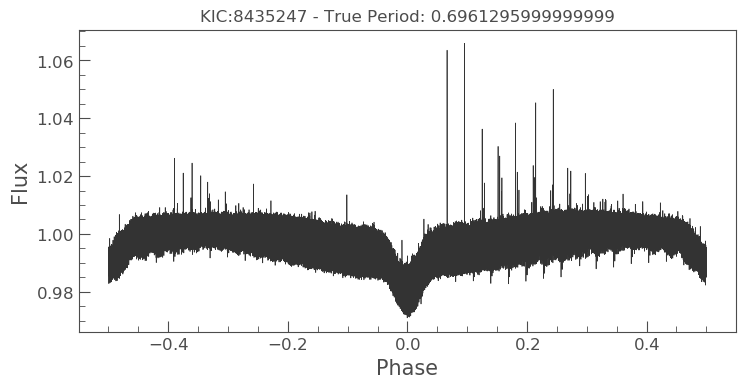

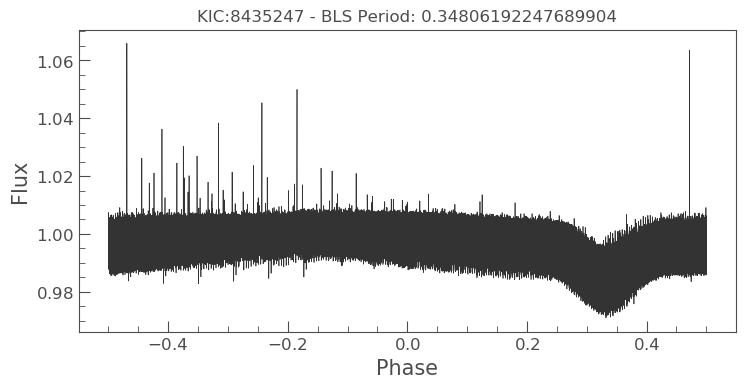

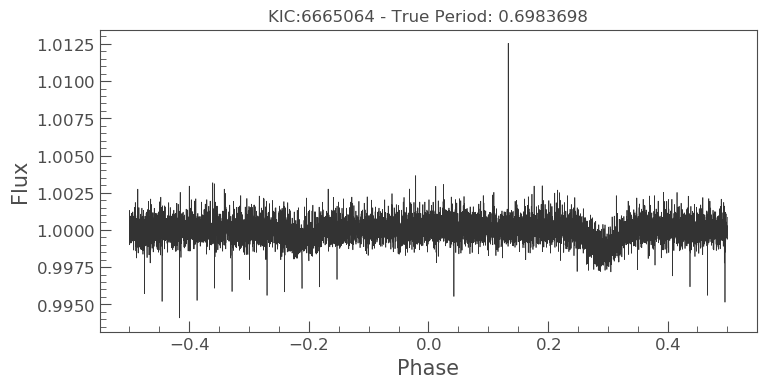

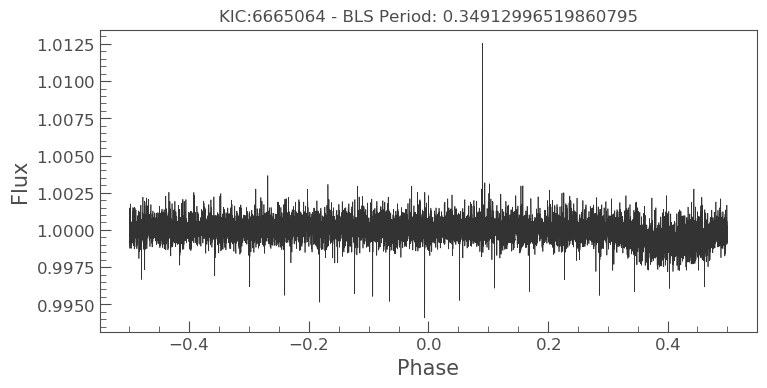

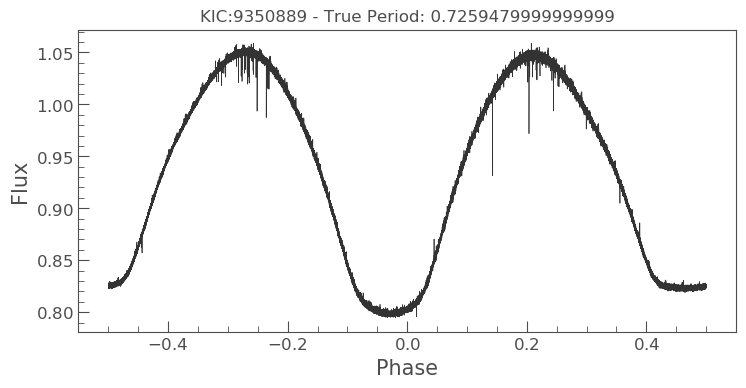

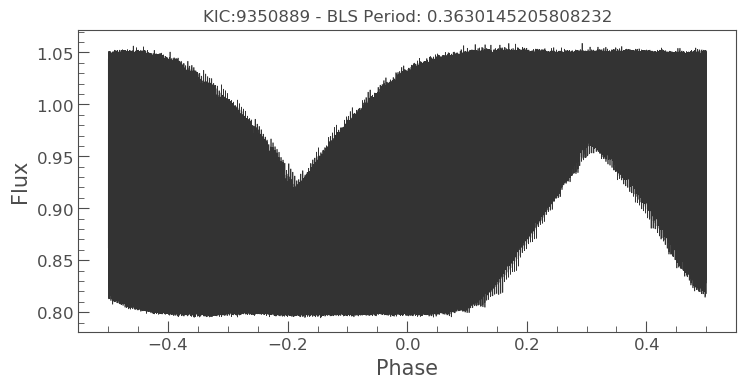

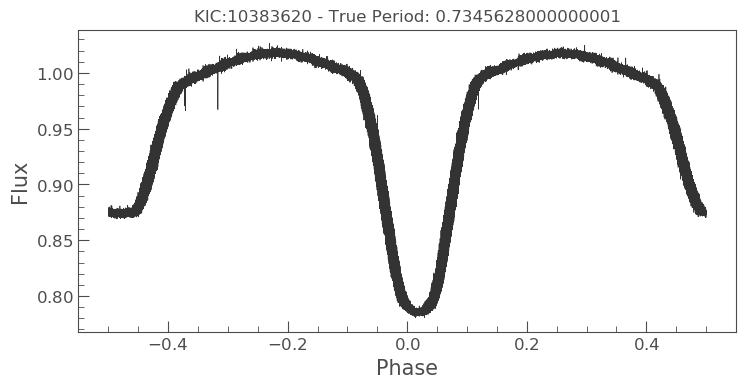

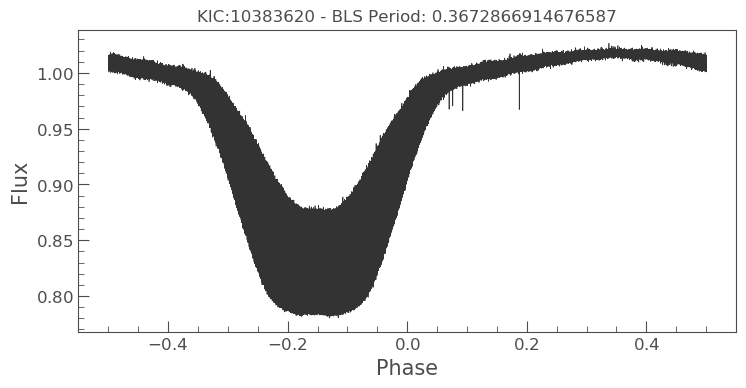

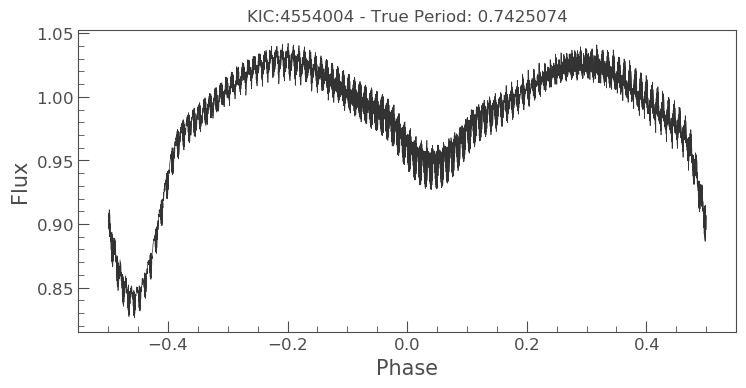

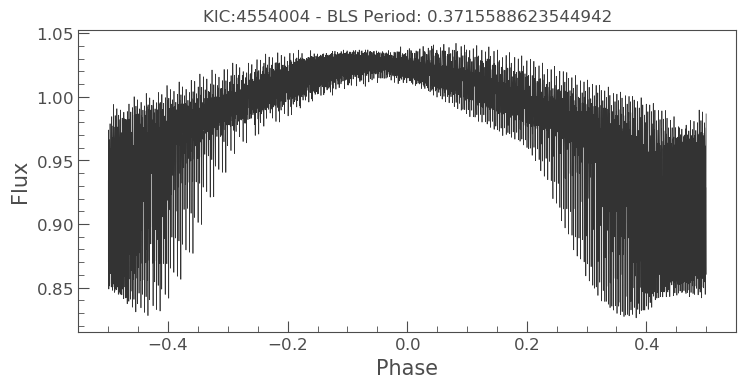

In [149]:
#look at EB folded lcs

#load data
incorrects_lessthan1 = lessboth[~keb_accuracy_less]
incorrects_biggerthan1 = greaterboth[~keb_accuracy_bigger]
corrects_lessthan1 = lessboth[keb_accuracy_less]
corrects_biggerthan1 = greaterboth[keb_accuracy_bigger]
# kep_table  ##incorr&corr
choice_table = incorrects_lessthan1

kics = choice_table['KIC'].to_numpy()
for count,kic in enumerate(kics): #[20:40]
    if count == 10: #b/c 2x plots per kic
        break
    else:
        keplerlc = kepEBopen(kic)
    #     flux=keplerlc.flux;time=keplerlc.time;fluxerr=keplerlc.flux_err
        per = kep_table[kep_table['KIC']==kic]['period_truth'].to_numpy()[0]
        perb = kep_table[kep_table['KIC']==kic]['period_bls'].to_numpy()[0]
        foldedlc_truth = keplerlc.fold(period=per)
        foldedlc_bls = keplerlc.fold(period=perb)
        foldedlc_truth.plot();plt.title('KIC:{} - True Period: {}'.format(kic,per))
        foldedlc_bls.plot();plt.title('KIC:{} - BLS Period: {}'.format(kic,perb))


# -----------------------------------  TESTS --------------------------------------------

In [21]:
# ## same speed - this isnt faster

# pgrid = period_grid()
# dgrid = duration_grid()
# times=[];fluxes=[];fluxerrs=[];allstats=[]
# for lc in test_LCs:
#     time = lc.time
#     flux = lc.flux
#     fluxerr = lc.flux_err
#     t,f,fe = flatten_lc(time,flux,fluxerr)
#     times.append(t);fluxes.append(f);fluxerrs.append(fe)
# number = 0; num_list=[]
# for i in tqdm(range(len(test_LCs))): #might have to +1
#     imp_t.sleep(1)
#     number += 2
# #     periodogram, stats = bls(pgrid,dgrid,times[i],fluxes[i],fluxerrs[i])
# #     allstats.append(stats)
#     num_list.append(number)
    

In [150]:
# for i in range(len(allstats)):
#     print(allstats[i])
# idx=20
# print('using per: {} with noise:{}'.format(test_Periods[idx],test_Noises[idx]))
# test = plot_lc(test_LCs[idx].time,test_LCs[idx].flux,test_LCs[idx].flux_err,ID='original')
# flat_t,flat_f,flat_fe = flatten_lc(test_LCs[idx].time, test_LCs[idx].flux, test_LCs[idx].flux_err)
# test2 = plot_lc(flat_t,flat_f,flat_fe,ID='FLATTENDED') #idx=20 shows funny behavior --clue to bug?

In [23]:
# t2,f2,fe2 = flatten_lc(flat_t,flat_f,flat_fe)

# blsgram, stats2 = bls(pgrid,dgrid,t2,f2,fe2)
# stats2.power,stats2.period

In [24]:
# pgrid = period_grid()
# dgrid = duration_grid()
# allstats=[]
# # f,ax = plt.subplots(5,1,figsize=(19,15))
# for lc in tqdm(range(5)):
#     imp_t.sleep(1) #time bar to track bls progress on the 10,000 lcs
#     t,f,fe = flatten_lc(flat_t,flat_f,flat_fe)
#     periodogram, stats = bls(pgrid,dgrid,t2,f2,fe2 )
#     allstats.append(stats)

In [25]:
# allstats[3].power,allstats[3].period,len(allstats)

In [26]:
# def returnNotMatches(a, b):
#     return [[x for x in a if x not in b], [x for x in b if x not in a]] #not in b , not in a



In [27]:
# a = list(pgrid)
# b = list(bls_outputs['injected_period'])

# notina,notinb = returnNotMatches(a,b)
# print(len(notina),len(notinb))

In [28]:
# t = np.isclose(pgrid,bls_outputs['injected_period'],atol=0.5)
# for count,i in enumerate(t):
#     if i == True:
#         print(count,i)

# print(len(b))
# notina

## need a fcn to determine transit depths for s/n

In [29]:
# flux is output from sim_lc....use avg - min = depth?...need clean signal tho w/o noise
# sim_lc gives it with noise...need flux from one_transit


In [30]:
print(len(periodograms),sample_size)
pgrid[200:215],len(pgrid)
1.4125-1.41094219, 1.41628326-1.4125 

625 625


(0.0015578099999999928, 0.003783259999999844)

In [31]:
len(pgrid)
# finding how many injected periods were in the period grid already ----
#----goal: determine how close pgrid has to be to true to get blsoutput that is true

#useful fcn - compares lists & returns what didnt match
def returnNotMatches(a, b):
    return [[x for x in a if x not in b], [x for x in b if x not in a]] #not in b , not in a

notinpgrid, notintruth = returnNotMatches(bls_outputs['injected_period'],bls_outputs['period'])
print(len(notinpgrid),len(notintruth)) #considering only 1/2 in pgrid..pipeline did well
#find max/min diff btween pgrid & truth for accuracy == False
falsedf = df.loc[df['accuracy']==False]
# falsedf['period']/falsedf['injected_period']
for rp in falsedf['injected_period']:
    diffs = np.abs([rp-i for i in pgrid])
    print('for injected: {} diff is {}'.format(rp,min(diffs))) #for diff = 0.0 the noise is higher than signal
    # need grid to reduce current diff of 0.0015578115623124944

550 589
for injected: 25.887500000000003 diff is 0.0004005160206403957
for injected: 25.887500000000003 diff is 0.0004005160206403957
for injected: 25.887500000000003 diff is 0.0004005160206403957
for injected: 25.887500000000003 diff is 0.0004005160206403957
for injected: 25.887500000000003 diff is 0.0004005160206403957
for injected: 25.887500000000003 diff is 0.0004005160206403957
for injected: 25.887500000000003 diff is 0.0004005160206403957
for injected: 25.887500000000003 diff is 0.0004005160206403957
for injected: 27.0 diff is 0.0
for injected: 27.0 diff is 0.0
for injected: 27.0 diff is 0.0
for injected: 27.0 diff is 0.0
for injected: 27.0 diff is 0.0
for injected: 27.0 diff is 0.0
for injected: 27.0 diff is 0.0
for injected: 27.0 diff is 0.0
for injected: 27.0 diff is 0.0
for injected: 27.0 diff is 0.0
for injected: 27.0 diff is 0.0
for injected: 27.0 diff is 0.0


In [32]:
pgrid[-230:-200]#,bls_outputs['period'][-26:-1]#,bls_outputs['injected_period']

array([26.75541822, 26.75648626, 26.7575543 , 26.75862234, 26.75969039,
       26.76075843, 26.76182647, 26.76289452, 26.76396256, 26.7650306 ,
       26.76609864, 26.76716669, 26.76823473, 26.76930277, 26.77037081,
       26.77143886, 26.7725069 , 26.77357494, 26.77464299, 26.77571103,
       26.77677907, 26.77784711, 26.77891516, 26.7799832 , 26.78105124,
       26.78211928, 26.78318733, 26.78425537, 26.78532341, 26.78639146])

In [33]:
# plt.hist(noise_levels,color='r')
# plt.hist(truedepths);
inj = 25.887500000000003
inj-25.88371674, 25.88905781-inj, (0.0015578099999999928, 0.003783259999999844)

(0.0037832600000022865,
 0.0015578099999977724,
 (0.0015578099999999928, 0.003783259999999844))

In [34]:
#finding max diff between values in pgrid
diffs = []
for i in range(len(pgrid)-1):
#     print(i)
    diff = pgrid[i+1] - pgrid[i] #used linspace so these should all be ~same
    diffs.append(diff)
print(max(diffs)) # all ~.005341....so need this to be reduced to ~.001


0.0010680427217097943


In [35]:
# ## tests for average flux err on TESS lc

# tic = 140801898
# sector = 1
# filepath = 'data/SECONDRUN/cleaned_LightCurves/{}/sector{}_lc.fits'.format(tic,sector)

# lc = fits.open(filepath)
# lc_data = lc[1].data
# time=lc_data.TIME; flux=lc_data.FLUX; flux_err=lc_data.FLUX_ERR
# plt.plot(flux,color='b',label='flux');
# plt.plot(flux_err,color='r',label='uncertainity');
# plt.legend()
# print('error range:',min(flux_err),max(flux_err))
# print('flux range:',min(flux),max(flux))
# print('signal to noise:',np.mean(flux)/np.mean(flux_err))